This script shows examples of use of the different classes defined in the folder [utils](utils/). 

It will present the following elements : 
- `sample_plan`: objects containing the different times where the data are sampled. There are various sample plan types available in this object (uniform, random, with batches, custom...). The classe definition is in the file [sample_plan.py](utils/sample_plan.py).
- `models_catalogue`: file containing different models to drive a dynamic. It is basically a function retruning the derivatives of the state vector depending on the time and the current state. For now, it contains models representing: an exponential decay, a Lotka-Voltera model for 2 populations with different holling response functions and a carrying capacity, and the same for N populations (with an example with 2 predators and 4 preys). The file is [models_catalogue.py](utils/models_catalogue.py).
- `data_generator`: objects containing a generator of simulated sampled data considering a sample plan and a model for the dynamics. It allows for different data generations (with a certain amount of noise for instance). The file is [data_generator.py](utils/data_generator.py).
- `PINN`: Physics Informed Neural Network, allowing to adjust a neural network to the sampled data considering the dynamics of the system. The file is [pinn.py](utils/pinn.py).
- `scipy_solver`: uses discrete methods and adjusts the parameters of the dynamics through integrative methods. The file is [scipy_fitting.py](utils/scipy_fitting.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# Sample plan 
*[Here](utils/sample_plan.py) is the concerned file.*

In [2]:
import utils.sample_plan as sp

Various methdos for the sampling plan are implemented:
- `uniform`: given `tmax` and `nbpoint`, it will create a uniform sample of `nbpoint` points between 0 and `tmax`. 
- `random`: given `tmax` and `nbpoint`, it will create a random sample of `nbpoint` points between 0 and `tmax`. 
- `batch_uniform`: it requires `tmax`, `nbpoint` and `batch_params` which is a dictionnary containing the number of batches ("nbr_batch") and the ratio between the time in the batches compared to the total time ("ratio_in_out_batch"). "nbr_batch" must be a divisor of `npoint`. It will create points between 0 and `tmax` divided into batches occuring between 
$\frac{ i * \text{tmax} } { \text{nb batch} }$ and $\frac{ (i + \text{ratio in out batch}) * \text{tmax} } { \text{nb batch} }$ for $i = 1, \ldots, \text{nb batch}$. Points are sampled uniformly within each batch. 
- `batch_random`: same thing but points are sampled randomly within each batch.
- `custom`: you just need to provide the `custom_plan` which is the list (or 1D array) containing all the sampling times you want in the sampling plan. 

## Uniform

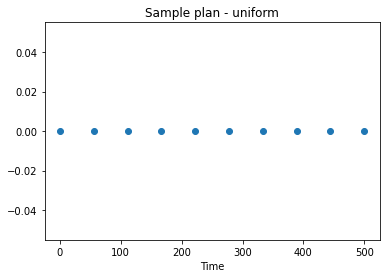

In [3]:
sample_plan1 = sp.sample_plan(tmax=500, nbpoint=10, plan_type="uniform", batch_params=None)
sample_plan1.plot_samples()

## Random

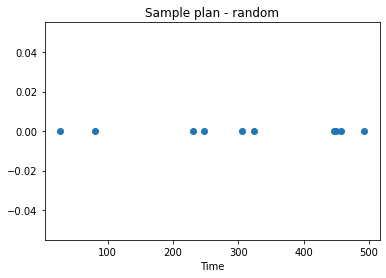

In [4]:
sample_plan2 = sp.sample_plan(tmax=500, nbpoint=10, plan_type="random", batch_params=None)
sample_plan2.plot_samples()

## Batch uniform

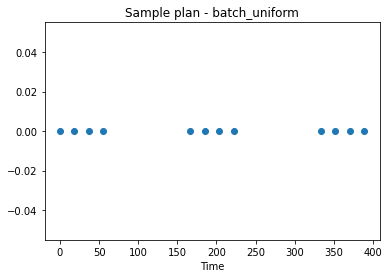

In [5]:
sample_plan3 = sp.sample_plan(tmax=500, nbpoint=12, plan_type="batch_uniform", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/3})
sample_plan3.plot_samples()

## Batch random

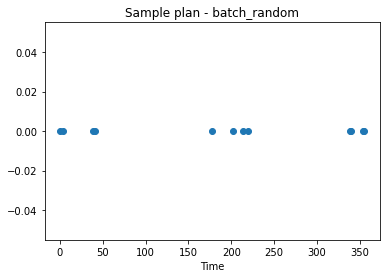

In [6]:
sample_plan4 = sp.sample_plan(tmax=500, nbpoint=12, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/3})
sample_plan4.plot_samples()

## Custom

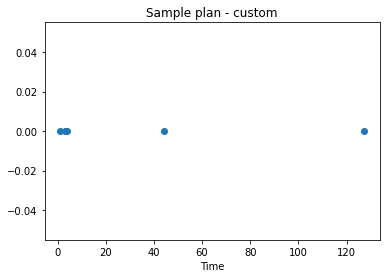

In [7]:
sample_plan5 = sp.sample_plan(plan_type="custom", custom_plan=np.array([1, 4, 127.34, 3, 44.21]))
sample_plan5.plot_samples()

# Model catalogue
*[Here](utils/models_catalogue.py) is the concerned file.*

Models considered here are ODEs: $X'(t) = f_\theta(t, X(t))$ where $f$ is a function depending on a list of scalara parameters $\theta$. 

The models provided are functions that take into arguments `t`, `state` ($X(t)$), and `param` (a dictionnary containing the scalar parameters of $\theta$, for instance `param = {theta_1: 1.23, theta_2: -3.45}`). 
Considering how other classes are defined in our code, `state` needs to be a list (a list of 1 element works), and it returns the list of the corresponding derivatives of the system $[\frac{dX_1}{dt}(t), \ldots, \frac{dX_m}{dt}(t)]$. And `param` need contain elements being scalars only (`param[thata_i]` must be a scalar).

*Since we will provide this function to pinn models, we suspect the library `deepxde` to require form $f$ to have only operations allowed on tensorflow objects.*

We defined the dynamics for an exponential decay, a Lotka-Voltera model for 2 populations with different holling response functions and a carrying capacity, and the same for N populations (with an example with 2 predators and 4 preys). We also set the parameters for this LV 6 populations in a compact dictionnary `params_6pop_dimless`which needs to be slightly modified to fit with the requirement of having only scalar values (not arrays), using the function `dict_dimless_params_compact_to_long`. These parameters are taken from Léo Lusardia's PhD thesis, p.215 and following: *Lusardia, L., 2023. Modélisation et prédiction de la dynamique d’un réseau trophique en réponse aux pressions d’origine anthropique. Université Paris-Saclay.*
 

In [8]:
from utils.models_catalogue import exp_decay_model_derivatives, lv_model_Npop_derivatives_noarray, lv_model_2pop_derivatives
from utils.models_catalogue import eco_to_dimless_2pop
from utils.models_catalogue import params_6pop_dimless, dict_dimless_params_compact_to_long

We display the dynamices for the different models. LV models are available for different Holling response functions: Holling 1, Holling 1 saturated, Holling 2, and Holling 3. 

## Exponential decay

Exponential decay parameter: 0.5


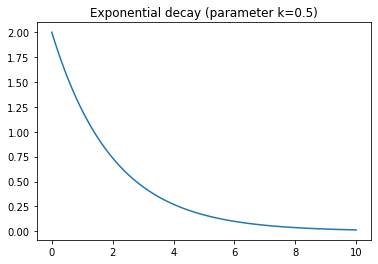

In [9]:
# Set the model parameters
param = {"k": 0.5}
print("Exponential decay parameter:", param["k"])

# Set the simulation parameters
tmax = 10
x_ini = 2
nb_p_t = 100

# Simulate the model
t_simu = np.linspace(0, tmax, nb_p_t)
X_simu = odeint(exp_decay_model_derivatives, [x_ini], t_simu, args=(param,), atol=1e-8, rtol=1e-11)

plt.figure()
plt.plot(t_simu, X_simu)
plt.title(f"Exponential decay (parameter k={param['k']})");

## LV 2 populations

Parameters: {'a1': 0.088, 'a2': 0.02, 'e': 1, 'c': 0.96, 'K': 0.034, 'S': 0.12, 'xR1': 0.12, 'xR2': 0.91, 'b': 8.333333333333334, 'a': 1.6}
Dimensionless parameters: {'kappa_tild': 0.030940000000000002, 'Tr1_tild': 11.363636363636365, 'Tr2_tild': 50.0, 'Tc_tild': 0.7861872559674757, 'Ta_tild': 5.723443223443223, 'lambda_tild': 11.041333333333334, 'func_resp': 'holling3', 'Tref': 10}
Response function: holling3


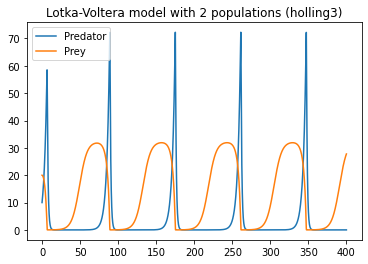

In [10]:
# Set the model parameters
func_resp = "holling3"
Tref = 10
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91}
eco_params_2pop["b"] = eco_params_2pop["e"] / eco_params_2pop["S"]
if func_resp == 'holling1' or func_resp == 'holling1_sat':
    eco_params_2pop["a"] = 0.086
elif func_resp == 'holling2':
    eco_params_2pop["a"] = 0.13
elif func_resp == 'holling3':
    eco_params_2pop["a"] = 1.6
dimless_params_2pop = eco_to_dimless_2pop(eco_params_2pop, func_resp=func_resp)
dimless_params_2pop["func_resp"] = func_resp
dimless_params_2pop["Tref"] = Tref

print("Parameters:", eco_params_2pop)
print("Dimensionless parameters:", dimless_params_2pop)
print("Response function:", func_resp)

# Set the simulation parameters
tmax = 400
x1_tild_ini, x2_tild_ini = 10, 20 # Predator, Prey
nb_p_t = 10000

# Simulate the model
t_simu = np.linspace(0, tmax, nb_p_t)
X_simu = odeint(lv_model_2pop_derivatives, [x1_tild_ini, x2_tild_ini], t_simu, 
                args=(dimless_params_2pop, ), atol=1e-8, rtol=1e-11)

plt.figure()
plt.plot(t_simu, X_simu, label=["Predator", "Prey"])
plt.title(f"Lotka-Voltera model with 2 populations ({func_resp})")
plt.legend();

## LV 6 populations

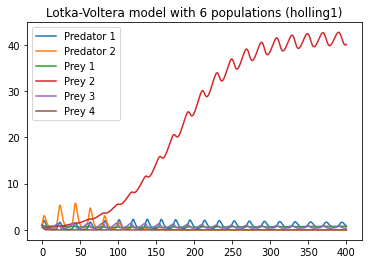

In [11]:
# Set the model parameters
func_resp = 'holling1'
Tref = 10
n_preds, n_preys = 2, 4
if func_resp == "holling1" or func_resp == "holling1_sat":  suff_hol = "H1"
elif func_resp == "holling2":                               suff_hol = "H2"
elif func_resp == "holling3":                               suff_hol = "H3"
dimless_params_6pop = {"kappa_tild": params_6pop_dimless["kappa_tild"],
                        "Tc_tild": params_6pop_dimless["Tc_tild_"+suff_hol],
                        "Ta_tild": params_6pop_dimless["Ta_tild_"+suff_hol],
                        "lambda_tild": params_6pop_dimless["lambda_tild_"+suff_hol],
                        "Tr_tild": params_6pop_dimless["Tr_tild"] }
dimless_params_6pop["func_resp"], dimless_params_6pop["Tref"] = func_resp, Tref
dimless_params_6pop["n_preds"], dimless_params_6pop["n_preys"] = n_preds, n_preys
dimless_params_6pop_long = dict_dimless_params_compact_to_long(dimless_params_6pop)

# Set the simulation parameters
t_max = 100
X_tild_ini = [1, 1, 1, 0.5, 1, 1]
nb_p_t = 10000

# Simulate the model
t_simu = np.linspace(0, tmax, nb_p_t)
X_simu = odeint(lv_model_Npop_derivatives_noarray, X_tild_ini, t_simu, 
                args=(dimless_params_6pop_long, ), atol=1e-8, rtol=1e-11)

plt.figure()
plt.plot(t_simu, X_simu, label=["Predator " + str(k+1) for k in range(n_preds)] + ["Prey " + str(k+1) for k in range(n_preys)] )
plt.title(f"Lotka-Voltera model with 6 populations ({func_resp})")
plt.legend();

# Data generator
*[Here](utils/data_generator.py) is the concerned file.*

The class `data_generator` allows to simulate sampled datat. 

First, we need to declare the generator. It requires a model, the dictionnary of the parameters for the model, a definition of the maximum time for the time window, the initial condition for the simulation, and some parameters used for the plots (labels of the state and name of the model). 
For instance: `dg.data_generator(model, params, t_max, init_state, labels_states=["Predator", "Prey"], model_name="Lotka-Volterra")`

Then, we can generate the date. To do so, we need to provide a sample plan, the noise intensity on the sampled data, and eventually a permissible range to prevent data to ba outside a reasonable range (for instance states that need to be positive). For instance: `datagen.get_data(plan=sample_plan, noise_intensity=0.1, noise_seed=None, plot_data=True, permissible_range=[0, np.inf], default_value=0)`. 

If we don't provide a sample plan, we need to provide the number of points for the default sample plan that will be uniform. For instance: `datagen.get_data(nbpoint_if_no_plan=10, noise_intensity=0.1, noise_seed=None, plot_data=True, permissible_range=[0, np.inf], default_value=0)`. 

In [12]:
import utils.data_generator as dg
import utils.sample_plan as sp

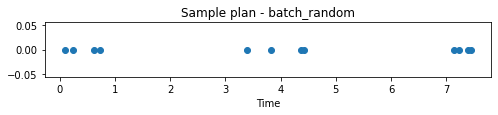

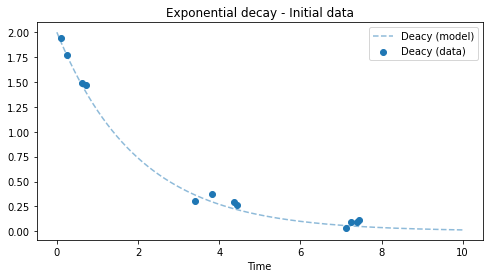

In [13]:
from utils.models_catalogue import exp_decay_model_derivatives

# Define the sample plan
t_max = 10
plt.figure(figsize=(8, 1))
sample_plan_exp1 = sp.sample_plan(tmax=t_max, nbpoint=12, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/3})
sample_plan_exp1.plot_samples()
plt.show()

# Declare the generator
param = {"k": 0.5}
x_ini = 2
datagen_exp1 = dg.data_generator(exp_decay_model_derivatives, param, t_max, [x_ini], 
                                 labels_states=["Deacy"], model_name="Exponential decay")

# Generate the data
nbpoint, noise_intensity, noise_seed = 20, 0.05, 123
plt.figure(figsize=(8, 4))
# datagen_exp1.get_data(nbpoint_if_no_plan=10, 
#                       noise_intensity=0.1, noise_seed=None, plot_data=True, 
#                       permissible_range=[-np.inf, np.inf], default_value=0)
# plt.show()
datagen_exp1.get_data(plan=sample_plan_exp1, 
                      noise_intensity=noise_intensity, noise_seed=None, plot_data=True, 
                      permissible_range=[-np.inf, np.inf], default_value=0)

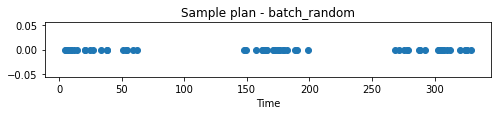

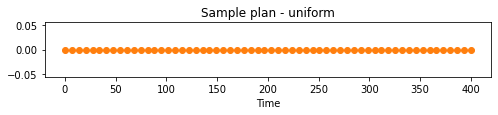

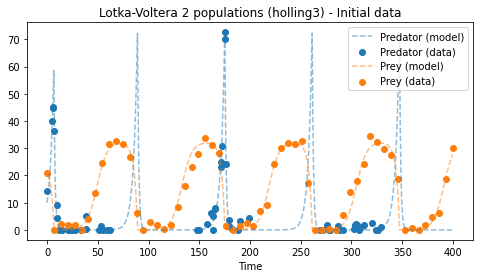

In [14]:
from utils.models_catalogue import lv_model_2pop_derivatives, eco_to_dimless_2pop

# Define the sample plan
t_max = 400
plt.figure(figsize=(8, 1))
sample_plan_LV2_1 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2})
sample_plan_LV2_1.plot_samples()
plt.figure(figsize=(8, 1))
sample_plan_LV2_2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="uniform")
sample_plan_LV2_2.plot_samples(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
plt.show()

# Declare the generator
Tref = 10
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                   "b":1/0.12, "Tref": Tref, "func_resp": "holling1", "a": 0.086} # b = e/S
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                   "b":1/0.12, "Tref": Tref, "func_resp": "holling2", "a": 0.13}  # b = e/S
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                   "b":1/0.12, "Tref": Tref, "func_resp": "holling3", "a": 1.6}   # b = e/S
dimless_params_2pop = eco_to_dimless_2pop(eco_params_2pop, func_resp=eco_params_2pop["func_resp"])
dimless_params_2pop["func_resp"], dimless_params_2pop["Tref"] = eco_params_2pop["func_resp"], Tref

X_ini = [10, 20] # Predator, Prey
datagen_LV2_1 = dg.data_generator(lv_model_2pop_derivatives, dimless_params_2pop, t_max, X_ini, 
                                  labels_states=["Predator", "Prey"], 
                                  model_name=f"Lotka-Voltera 2 populations ({dimless_params_2pop['func_resp']})")

# Generate the data
noise_intensity = 3
plt.figure(figsize=(8, 4))
datagen_LV2_1.get_data(plan=[sample_plan_LV2_1, sample_plan_LV2_2], noise_intensity=noise_intensity, noise_seed=None, plot_data=True, 
                      permissible_range=[0, np.inf], default_value=0)

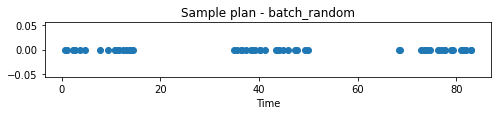

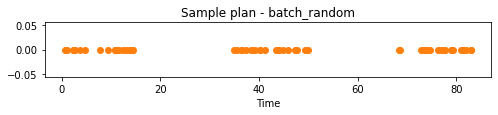

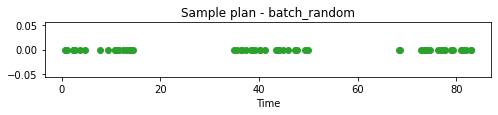

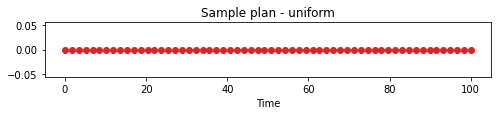

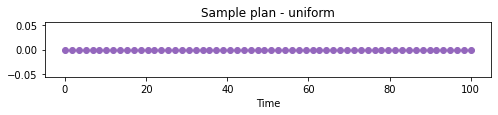

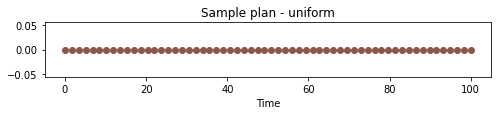

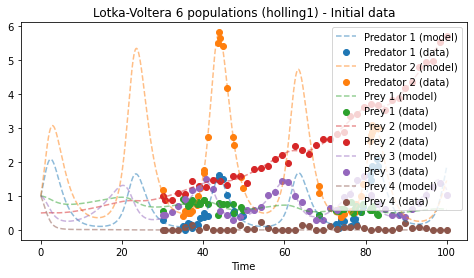

In [15]:
from utils.models_catalogue import lv_model_Npop_derivatives_noarray, params_6pop_dimless, dict_dimless_params_compact_to_long

# Define the sample plan
t_max = 100
sample_plan_LV6_1 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2})
sample_plan_LV6_2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="uniform")
lst_sample_plan_LV6 = [sample_plan_LV6_1]*3 + [sample_plan_LV6_2]*3
for i in range(len(lst_sample_plan_LV6)):
    plt.figure(figsize=(8, 1))
    lst_sample_plan_LV6[i].plot_samples(color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
plt.show()

# Declare the generator
func_resp = 'holling1'
Tref = 10
n_preds, n_preys = 2, 4
if func_resp == "holling1" or func_resp == "holling1_sat":  suff_hol = "H1"
elif func_resp == "holling2":                               suff_hol = "H2"
elif func_resp == "holling3":                               suff_hol = "H3"
dimless_params_6pop = {"kappa_tild": params_6pop_dimless["kappa_tild"],
                        "Tc_tild": params_6pop_dimless["Tc_tild_"+suff_hol],
                        "Ta_tild": params_6pop_dimless["Ta_tild_"+suff_hol],
                        "lambda_tild": params_6pop_dimless["lambda_tild_"+suff_hol],
                        "Tr_tild": params_6pop_dimless["Tr_tild"] }
dimless_params_6pop["func_resp"], dimless_params_6pop["Tref"] = func_resp, Tref
dimless_params_6pop["n_preds"], dimless_params_6pop["n_preys"] = n_preds, n_preys
dimless_params_6pop_long = dict_dimless_params_compact_to_long(dimless_params_6pop)

X_ini = [1, 1, 1, 0.5, 1, 1] # 2 predators, 4 preys
datagen_LV6_1 = dg.data_generator(lv_model_Npop_derivatives_noarray, dimless_params_6pop_long, t_max, X_ini, 
                                  labels_states=["Predator " + str(k+1) for k in range(n_preds)] + ["Prey " + str(k+1) for k in range(n_preys)], 
                                  model_name=f"Lotka-Voltera 6 populations ({dimless_params_6pop_long['func_resp']})")

# Generate the data
noise_intensity = 0.1
plt.figure(figsize=(8, 4))
datagen_LV6_1.get_data(plan=lst_sample_plan_LV6, noise_intensity=noise_intensity, noise_seed=None, plot_data=True, 
                       t_start_all_sample = 30, permissible_range=[0, np.inf], default_value=0)

# PINN
*[Here](utils/pinn.py) is the concerned file.*

This class allow to generate a Physics Informed Neural Network to adjust a neural network on the data. It requires generated data from a data_generator, and a model for the dynamics. 

First we need to declare the PINN with:
- the model used for the dynamics,
- the data_generator contaning generated data,
- the dictionnary of the parameters that we want to fit,
- the dictionnary of the parameters that are fixed,
- the upper time limit for the range on which the PINN will be fitted (it could be greater than the time of last data sampled if we want to extrapolate).

For instance: `model_pinn_exp = pinn(exp_decay_model_derivatives, datagen_exp, {"k":0.2}, {}, t_max_geom=1.5*t_max)`

Then, we can launch the training of the model, with:
- the learning rate,
- the neural network architecture = the list of the number of neurones for each layer. The size of the last layer needs to be the same as the state vector,
- the activation functions, 
- the initial condition ("Glorot normal" seems to work)
- weights = for each part of training, we can give the weight attributed to the loss related to the PDE, the boundary conditions, or the data. It is a list (of lengeth equal to the number of ârts in the training) of lists (all the weights for the PDE loss of output 1, ..., output m, then for the boundary conditions loss of output 1, ..., output m, and finally the data loss of output 1, ..., output m),
- niter_weights = a list of the numbers of iterations in each part of the training,
- the suffix of the file exported during the training (the prefix is the datetime). 

For instance: `model_pinn_exp.compile_train_model(lr=1e-3, nnlayers = [1] + [128] * 3 + [1], activation_function="swish", initcond="Glorot normal", weights=[[0, 2, 2], [5, 2, 2]], niter_weights=[1000,3000], file_var_export='exp')`. 


After the training, we can display the results with class methods:
- `basic_plot`: the PINN prediction of the neural network on the data. `elements_to_plot` is a dictionnary containing the lists of indices of the state vector to plot, for the simulation, the data, and the prediction. 
- `plot_convergence`: reports the evolution of each parameters fitted in the dynamics. 
- `plot_predicted_dynamic`: displays the final parameters fitted and simulate the associated dynamics. It's different from the PINN prediction. Here we look at the fitted parameters and we simulate the exact dynamics. In `basic_plot`, we see what returns the neural network (which is a composed function of t) for each t. 
- `plot_loss_history`: displays the evolution of each loss components
- `gif_evolution`: displays the evolution of the dynamics fitted simulated from the parameters, along the training

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from utils.pinn import *
import utils.data_generator as dg
import utils.sample_plan as sp

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



## Exponential decay

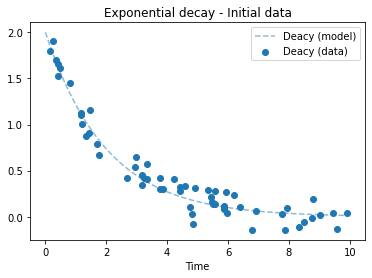

In [17]:
from utils.models_catalogue import exp_decay_model_derivatives

param = {"k": 0.5}
t_max, x_ini = 10, 2
sample_plan_exp2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="random")
datagen_exp2 = dg.data_generator(exp_decay_model_derivatives, param, t_max, [x_ini], 
                                 labels_states=["Deacy"], model_name="Exponential decay")
datagen_exp2.get_data(plan=sample_plan_exp2, noise_intensity=0.1, noise_seed=None, plot_data=True, 
                      permissible_range=[-np.inf, np.inf], default_value=0)

- - - - Train the PINN - - - -
Fitted parameters:  k
Fixed parameters:  
Learning rate:  0.001
Architecture:  [1, 128, 128, 128, 1] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.121223 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.746155 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.83e-03, 6.40e+00, 9.84e-01]    [5.83e-03, 6.40e+00, 9.84e-01]    []  
40        [7.38e-02, 1.41e-01, 1.75e-01]    [7.38e-02, 1.41e-01, 1.75e-01]    []  
80        [2.01e-02, 1.63e-04, 2.95e-02]    [2.01e-02, 1.63e-04, 2.95e-02]    []  
120       [1.29e-02, 6.07e-04, 2.81e-02]    [1.29e-02, 6.07e-04, 2.81e-02]    []  
160       [8.98e-03, 1.99e-04, 2.69e-02]    [8.98e-03, 1.99e-04, 2.69e-02]    []  
200       [6.05e-03, 1.32e-04, 2.61e-02]    [6.05e-03, 1.32e-04, 2.61e-02]    []  
240       [4.10e-03, 7.41e-05, 2.55e-02]    [4.10e-03, 7.41e-05, 2.55e-02]    []  
280       [2.78e-03, 3.89e-05, 2.49e-02]    [2.78e-03, 3.89e-05, 2.49e-02]    []  
320       [2.12e-03, 2.70e-05, 2.43e-02]    [2.12e-03, 2.70e-05, 2.43e-02]    []  
360       [1.34e-03, 7.63e-06, 2.40e-02]    [1.34e-03, 7.63e-06, 2.40e-02]    []  
400       [8.74e-04, 1.14e-06, 2.3

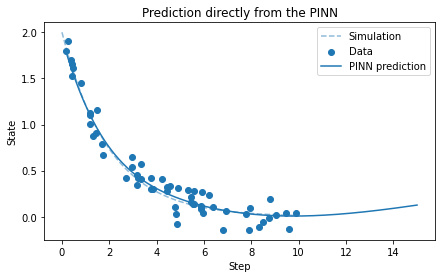

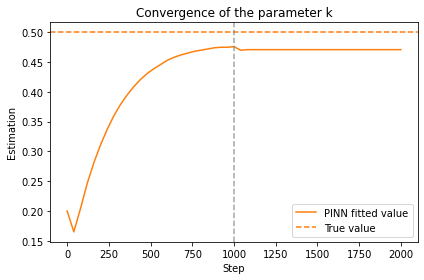

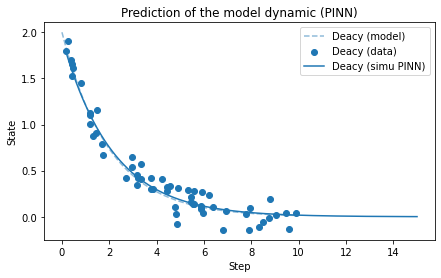

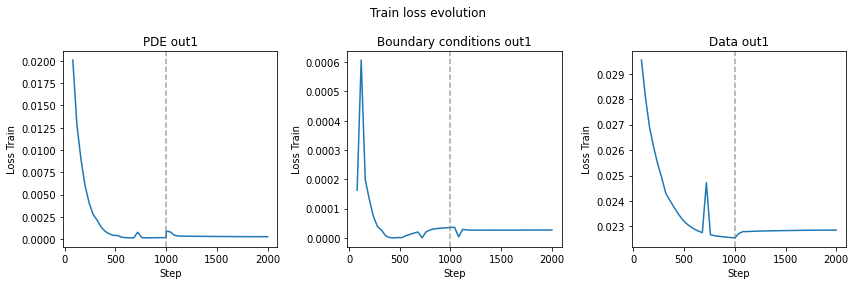

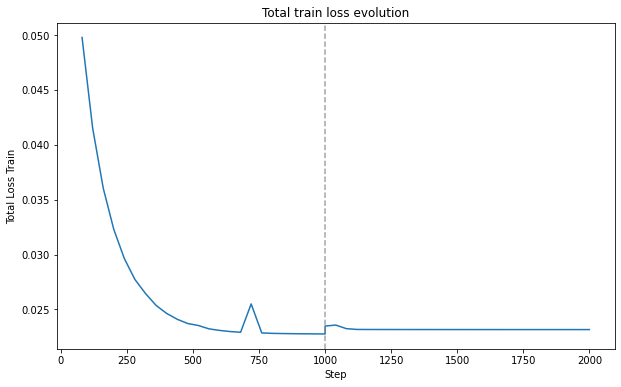

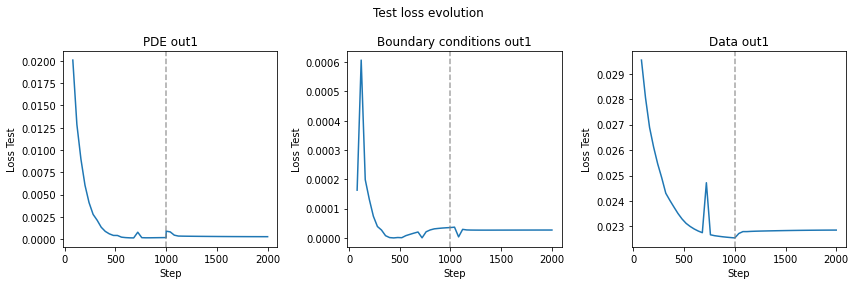

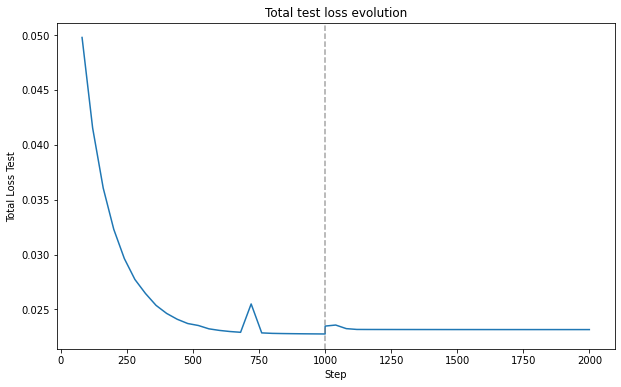

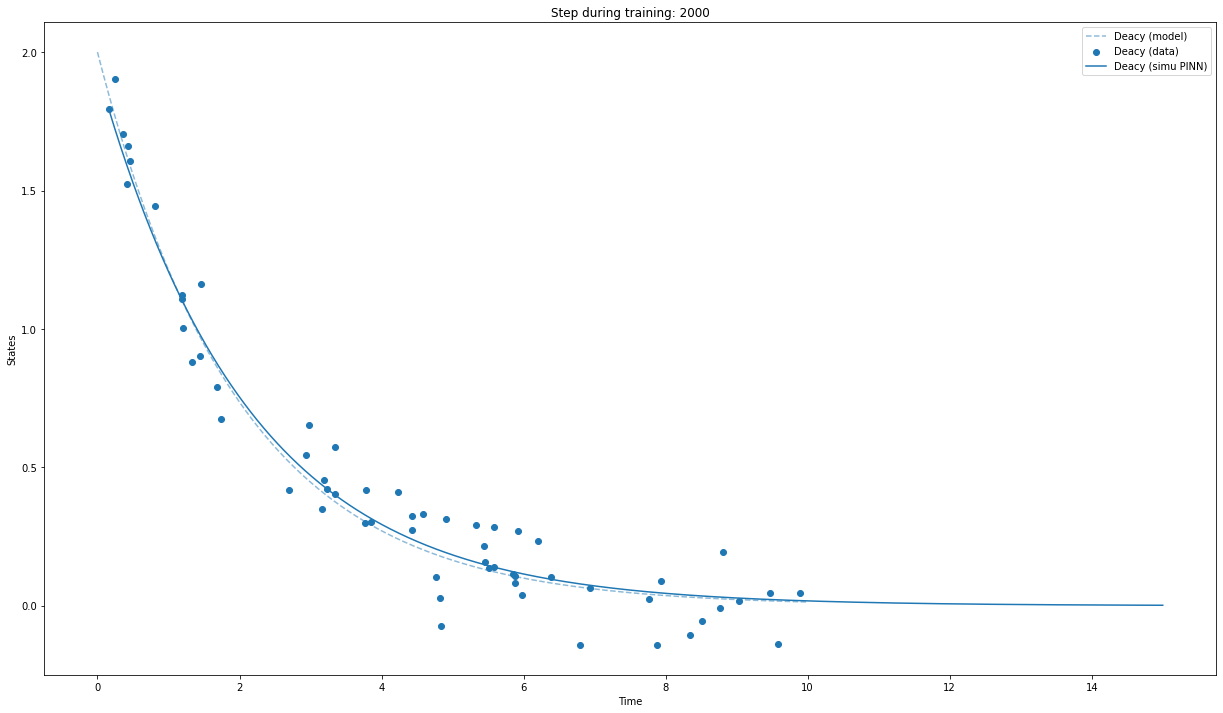

In [18]:
model_pinn_exp2 = pinn(exp_decay_model_derivatives, datagen_exp2, {"k":0.2}, {}, t_max_geom=1.5*t_max)

model_pinn_exp2.get_train_data()
pde_weights, bc_weights, data_weights = [5], [2], [2]
weights = [[1] + bc_weights + data_weights, pde_weights + bc_weights + data_weights]
lr = 1e-3

model_pinn_exp2.compile_train_model(lr=lr, nnlayers = [1] + [128] * 3 + [1],
                              activation_function="swish", initcond="Glorot normal",
                              weights=weights, niter_weights=[1000,1000], file_var_export='exp')

model_pinn_exp2.basic_plot(elements_to_plot={"simulation":[0], "data":[0], "prediction":[0]}, file_save_fig=None)
model_pinn_exp2.plot_convergence(file_save_fig=None)
model_pinn_exp2.plot_predicted_dynamic(elements_to_plot={"simulation":[0], "data":[0], "prediction":[0]},
                                       file_save_fig=None, nb_p_t=10000)
model_pinn_exp2.plot_loss_history(file_save_fig=None, elements_to_plot=["loss_train", "loss_test"], 
                                  start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
model_pinn_exp2.gif_evolution(elements_to_plot={"simulation":[0], "data":[0], "prediction":[0]}, 
                               file_save_gif='exp2.gif', nb_p_t=10000, max_gif_duration_in_sec=5)

## LV 2 populations

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from utils.pinn import *
import utils.data_generator as dg
import utils.sample_plan as sp

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



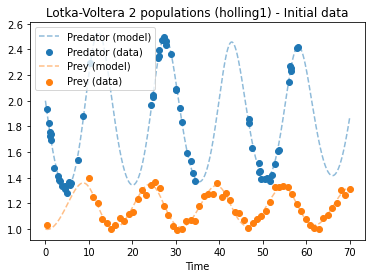

In [20]:
from utils.models_catalogue import lv_model_2pop_derivatives, eco_to_dimless_2pop

Tref = 10
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                   "b":1/0.12, "Tref": Tref, "func_resp": "holling1", "a": 0.086} # b = e/S
dimless_params_2pop = eco_to_dimless_2pop(eco_params_2pop, func_resp=eco_params_2pop["func_resp"])
dimless_params_2pop["func_resp"], dimless_params_2pop["Tref"] = eco_params_2pop["func_resp"], Tref
t_max = 70
X_ini = [2, 1] # Predator, Prey

datagen_LV2_2 = dg.data_generator(lv_model_2pop_derivatives, dimless_params_2pop, t_max, X_ini, labels_states=["Predator", "Prey"], 
                                  model_name=f"Lotka-Voltera 2 populations ({dimless_params_2pop['func_resp']})")

# sample_plan_LV2_2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="random")
# sample_plan_LV2_2 = sp.sample_plan(tmax=t_max, plan_type="custom", custom_plan=np.linspace(10, t_max, 60))
# sample_plan_LV2_2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="uniform")
sample_plan_LV2_2 = [sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2}),
                     sp.sample_plan(tmax=t_max, plan_type="custom", custom_plan=np.linspace(10, t_max, 60))]
datagen_LV2_2.get_data(plan=sample_plan_LV2_2, noise_intensity=0.03, noise_seed=None, plot_data=True, 
                      permissible_range=[0, np.inf], default_value=10)

- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild ; Tr1_tild ; Tr2_tild ; Tc_tild ; Ta_tild ; lambda_tild
Fixed parameters:  func_resp ; Tref
Learning rate:  0.001
Architecture:  [1, 128, 128, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.156646 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.433042 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.54e+00, 1.66e+00, 1.87e+01, 5.20e+00, 7.02e-01, 2.95e+00]    [1.54e+00, 1.66e+00, 1.87e+01, 5.20e+00, 7.02e-01, 2.95e+00]    []  
120       [8.14e-02, 2.27e-02, 4.64e-03, 3.24e-04, 9.64e-02, 4.34e-03]    [8.14e-02, 2.27e-02, 4.64e-03, 3.24e-04, 9.64e-02, 4.34e-03]    []  
240       [4.08e-02, 1.09e-02, 4.91e-04, 4.06e-04, 4.10e-02, 3.28e-03]    [4.08e-02, 1.09e-02, 4.91e-04, 4.06e-04, 4.10e-02, 3.28e-03]    []  
360       [2.28e-02, 6.57e-03, 1.28e-04, 2.17e-04, 2.81e-02, 3.22e-03]    [2.28e-02, 6.57e-03, 1.28e-04, 2.17e-04, 2.81e-02, 3.22e-03]    []  
480       [1.32e-02, 4.17e-03, 4.22e-05, 1.15e-04, 2.26e-02, 3.17e-03]    [1.32e-02, 4.17e-03, 4.22e-05, 1.15e-04, 2.26e-02, 3.17e-03]    []  
600       [7.68e-03, 2.75e-03, 1.59e-05, 5.31e-05, 1.91e-02, 3.09e-03]    [7.68e-03, 2.75

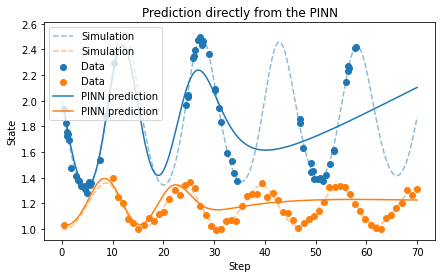

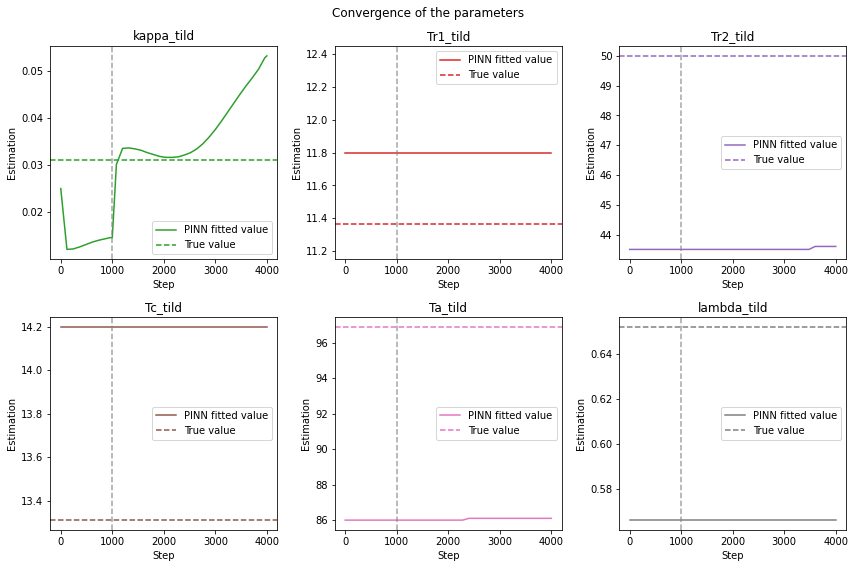

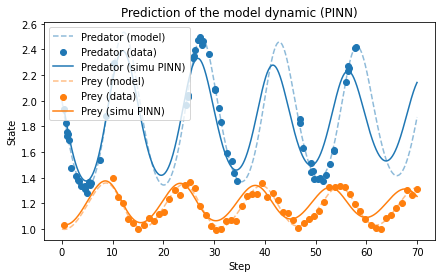

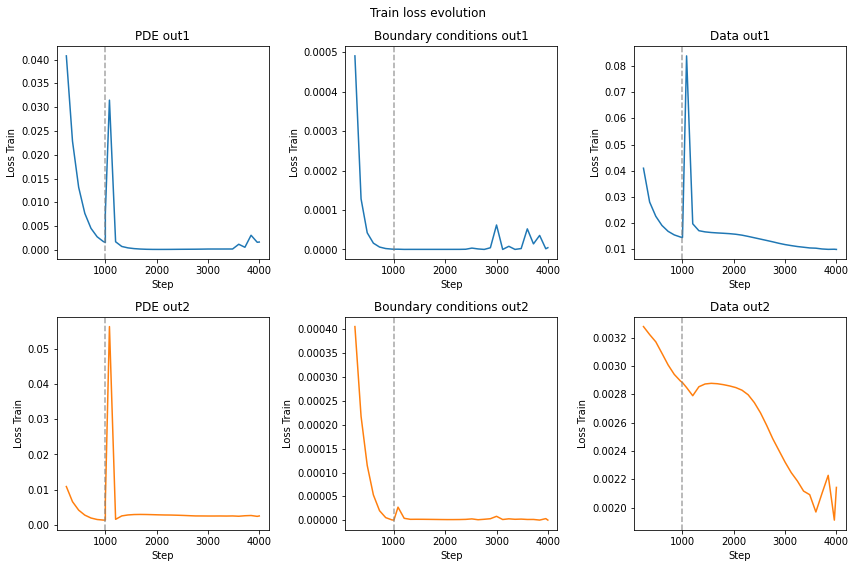

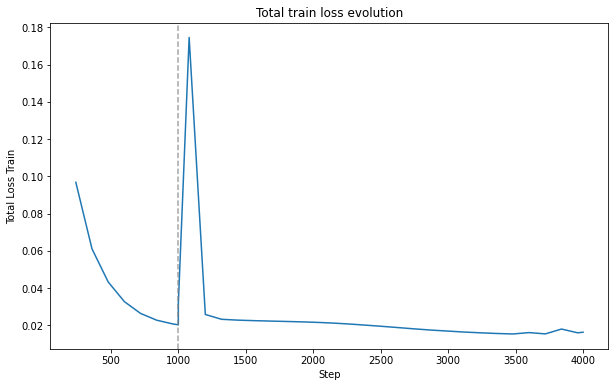

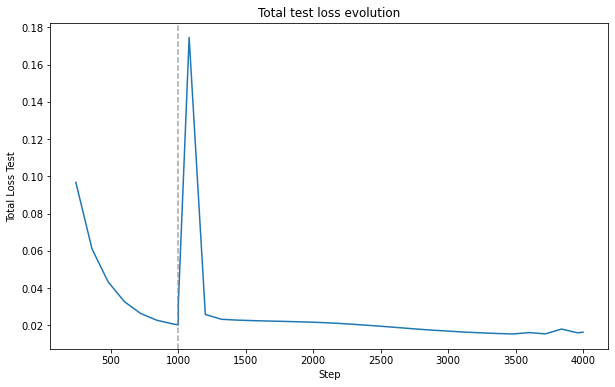

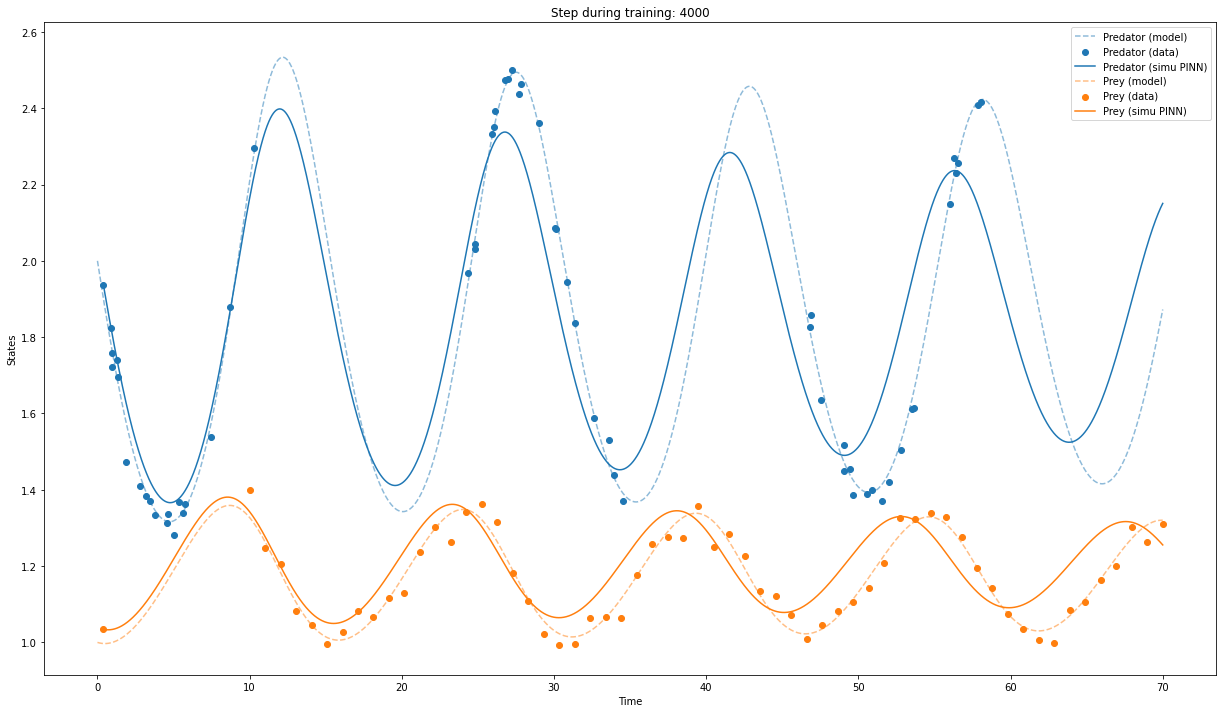

In [21]:
dimless_params_2pop_fitted = {key: value * (1+np.random.normal(0, 0.1)) \
                              for key, value in dimless_params_2pop.items() \
                              if key in ['kappa_tild', 'Tr1_tild', 'Tr2_tild', 'Tc_tild', 'Ta_tild', 'lambda_tild']}
dimless_params_2pop_fixed = {key: value for key, value in dimless_params_2pop.items() \
                             if key not in ['kappa_tild', 'Tr1_tild', 'Tr2_tild', 'Tc_tild', 'Ta_tild', 'lambda_tild']}
model_pinn_LV2_2 = pinn(lv_model_2pop_derivatives, datagen_LV2_2, 
                        dimless_params_2pop_fitted, dimless_params_2pop_fixed)

model_pinn_LV2_2.get_train_data()
pde_weights, bc_weights, data_weights = [10,10], [5,5], [0.2,0.2]
weights = [[2] * 2 + bc_weights + data_weights, pde_weights + bc_weights + data_weights]
lr = 1e-3

model_pinn_LV2_2.compile_train_model(lr=lr, nnlayers = [1] + [128] * 3 + [2],
                              activation_function="swish", initcond="Glorot normal",
                              weights=weights, niter_weights=[1000,3000], file_var_export='LV2_2')

model_pinn_LV2_2.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=None)
model_pinn_LV2_2.plot_convergence(file_save_fig=None)
model_pinn_LV2_2.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]},
                                        file_save_fig=None, nb_p_t=10000)
model_pinn_LV2_2.plot_loss_history(file_save_fig=None, elements_to_plot=["loss_train"], 
                                   start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
model_pinn_LV2_2.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                               file_save_gif='LV_2.gif', nb_p_t=10000, max_gif_duration_in_sec=5)

## LV 2 populations fixed params

- - - - Train the PINN - - - -
Fitted parameters:  lambda_tild
Fixed parameters:  kappa_tild ; Tr1_tild ; Tr2_tild ; Tc_tild ; Ta_tild ; func_resp ; Tref
Learning rate:  0.001
Architecture:  [1, 128, 128, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.145043 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.183971 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.31e+01, 4.40e-01, 1.87e+01, 5.30e+00, 9.56e-01, 6.33e-01]    [1.31e+01, 4.40e-01, 1.87e+01, 5.30e+00, 9.56e-01, 6.33e-01]    []  
240       [3.55e-02, 7.67e-03, 3.35e-04, 3.46e-03, 3.10e-02, 2.78e-03]    [3.55e-02, 7.67e-03, 3.35e-04, 3.46e-03, 3.10e-02, 2.78e-03]    []  
480       [3.07e-03, 2.04e-03, 2.79e-07, 2.07e-05, 2.11e-02, 2.74e-03]    [3.07e-03, 2.04e-03, 2.79e-07, 2.07e-05, 2.11e-02, 2.74e-03]    []  
720       [5.85e-04, 1.92e-03, 2.66e-07, 1.29e-06, 1.92e-02, 2.66e-03]    [5.85e-04, 1.92e-03, 2.66e-07, 1.29e-06, 1.92e-02, 2.66e-03]    []  
960       [3.11e-04, 2.09e-03, 4.98e-07, 6.04e-06, 1.86e-02, 2.64e-03]    [3.11e-04, 2.09e-03, 4.98e-07, 6.04e-06, 1.86e-02, 2.64e-03]    []  
1200      [2.62e-04, 2.16e-03, 5.50e-07, 7.25e-06, 1.83e-02, 2.64e-03]    [2.62e-04, 2.16

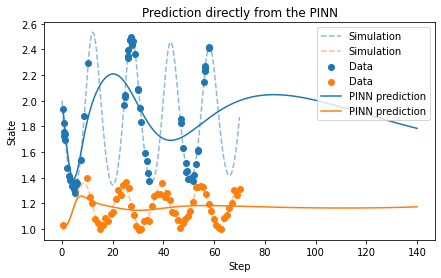

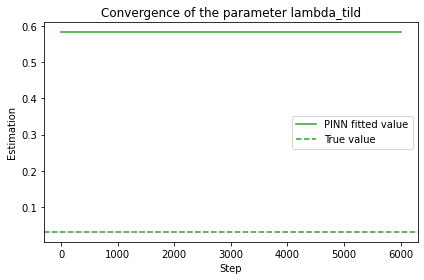

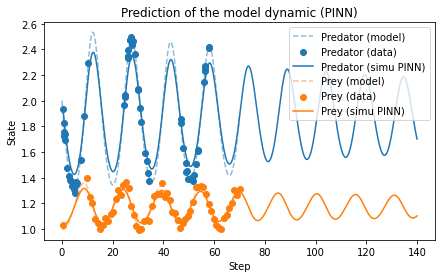

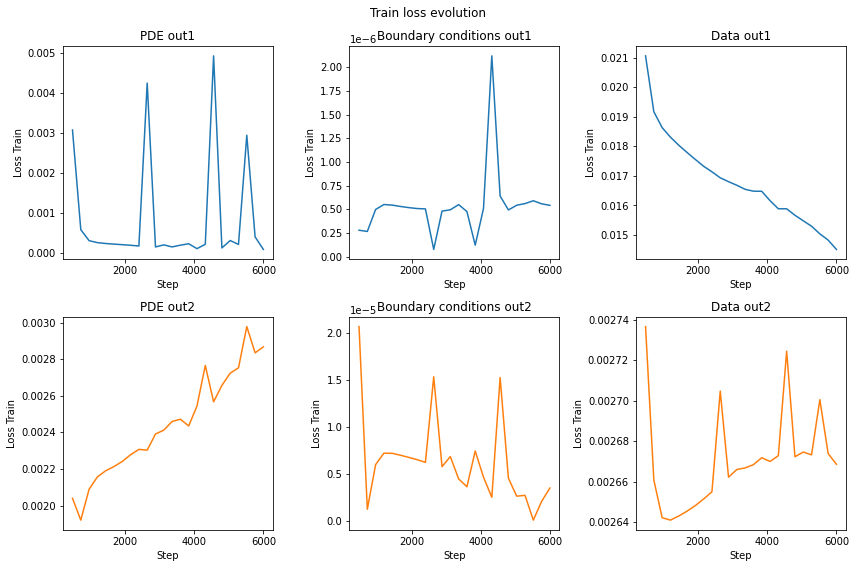

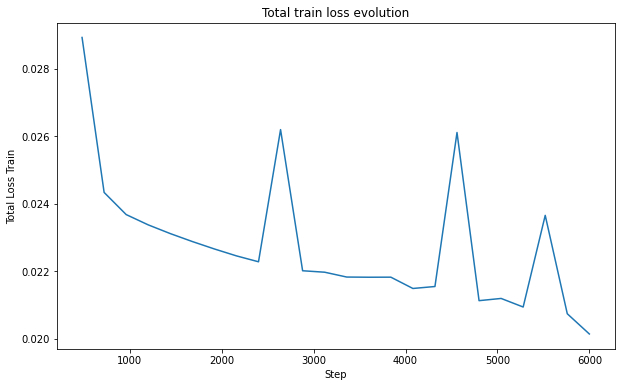

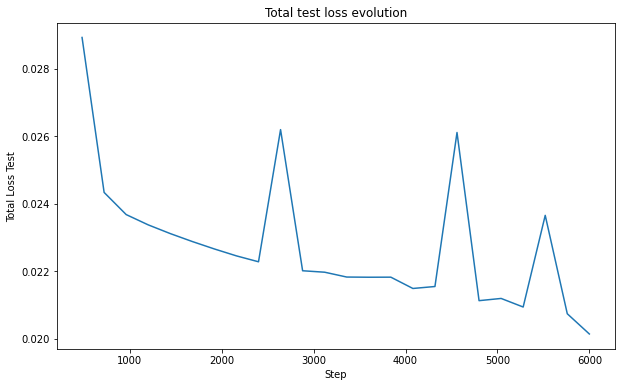

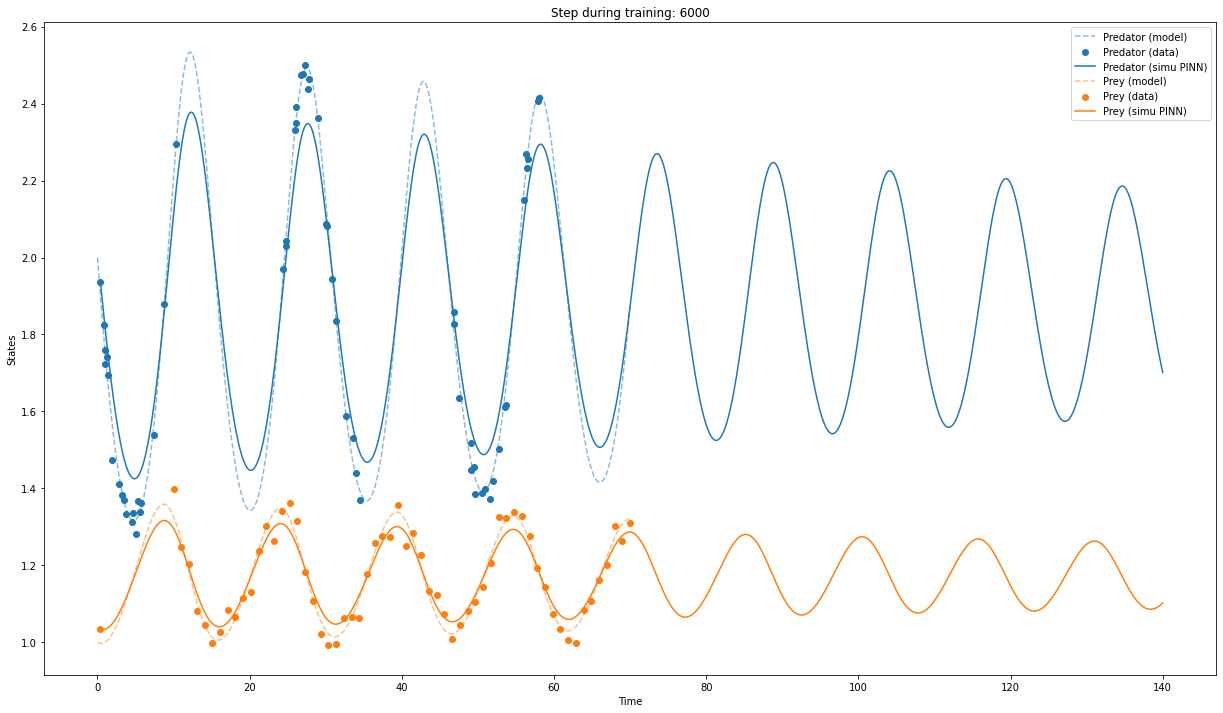

In [22]:
# fitted_params = ['kappa_tild', 'Tr1_tild', 'Tr2_tild', 'Tc_tild', 'Ta_tild', 'lambda_tild']
fitted_params = ['lambda_tild']
dimless_params_2pop_fitted = {key: value * (1+np.random.normal(0, 0.1)) \
                              for key, value in dimless_params_2pop.items() if key in fitted_params}
dimless_params_2pop_fixed = {key: value for key, value in dimless_params_2pop.items() if key not in fitted_params}
model_pinn_LV2_3 = pinn(lv_model_2pop_derivatives, datagen_LV2_2, 
                        dimless_params_2pop_fitted, dimless_params_2pop_fixed, t_max_geom=2*t_max)
model_pinn_LV2_3.get_train_data()
bc_weights, data_weights, pde_weights = [5,5], [0.2,0.2], [10,10]
weights = [pde_weights + bc_weights + data_weights]
lr = 1e-3

model_pinn_LV2_3.compile_train_model(lr=lr, nnlayers = [1] + [128] * 3 + [2], activation_function="swish", initcond="Glorot normal",
                              weights=weights, niter_weights=[6000], metrics=[], file_var_export='LV2_3')

model_pinn_LV2_3.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=None)
model_pinn_LV2_3.plot_convergence(file_save_fig=None)
model_pinn_LV2_3.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]},
                                        file_save_fig=None, nb_p_t=10000)
model_pinn_LV2_3.plot_loss_history(file_save_fig=None, elements_to_plot=["loss_train"], 
                                   start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
model_pinn_LV2_3.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]},
                               file_save_gif='LV2_3.gif', nb_p_t=10000, max_gif_duration_in_sec=5)

- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild
Fixed parameters:  Tr1_tild ; Tr2_tild ; Tc_tild ; Ta_tild ; lambda_tild ; func_resp ; Tref
Learning rate:  0.001
Architecture:  [1, 128, 128, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...


c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.300819 s

'compile' took 2.538522 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.68e+00, 2.30e-01, 1.87e+01, 5.45e+00, 4.58e-01, 2.21e-01]    [1.68e+00, 2.30e-01, 1.87e+01, 5.45e+00, 4.58e-01, 2.21e-01]    []  
240       [1.82e-02, 7.53e-03, 1.01e-04, 1.56e-03, 2.85e-02, 2.88e-03]    [1.82e-02, 7.53e-03, 1.01e-04, 1.56e-03, 2.85e-02, 2.88e-03]    []  
480       [1.16e-03, 2.02e-03, 2.29e-07, 9.77e-06, 1.88e-02, 2.65e-03]    [1.16e-03, 2.02e-03, 2.29e-07, 9.77e-06, 1.88e-02, 2.65e-03]    []  
720       [5.89e-03, 1.95e-03, 5.22e-07, 4.46e-06, 1.71e-02, 2.68e-03]    [5.89e-03, 1.95e-03, 5.22e-07, 4.46e-06, 1.71e-02, 2.68e-03]    []  
960       [5.25e-04, 2.19e-03, 1.10e-06, 5.04e-06, 1.68e-02, 2.62e-03]    [5.25e-04, 2.19e-03, 1.10e-06, 5.04e-06, 1.68e-02, 2.62e-03]    []  
1200      [1.34e-04, 2.33e-03, 1.06e-06, 4.63e-06, 1.64e-02, 2.6

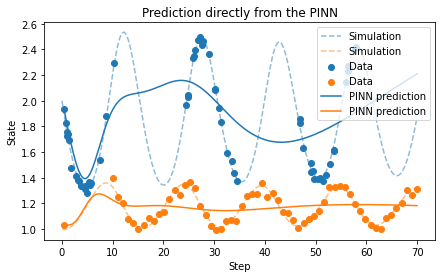

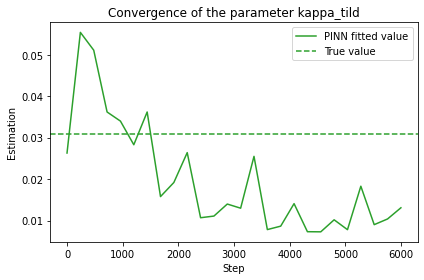

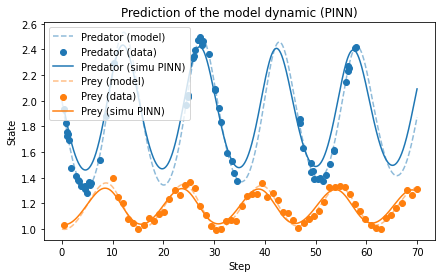

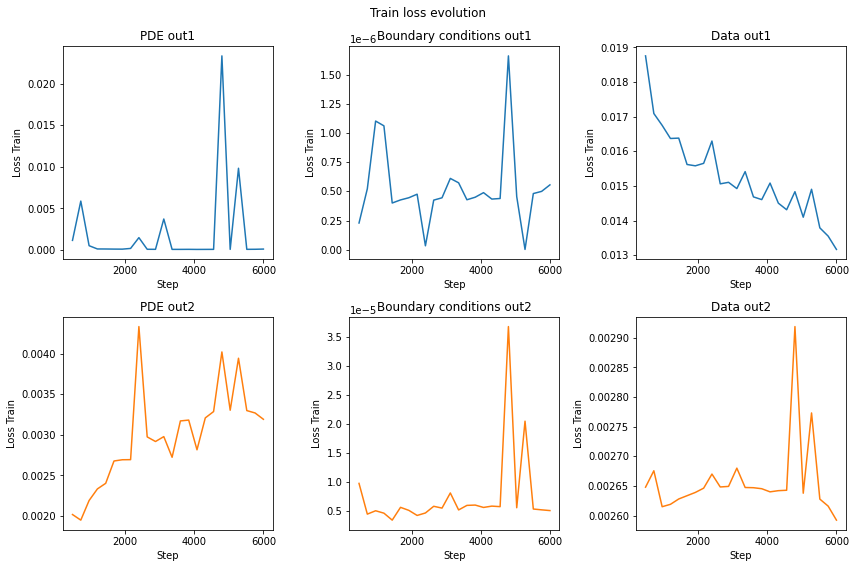

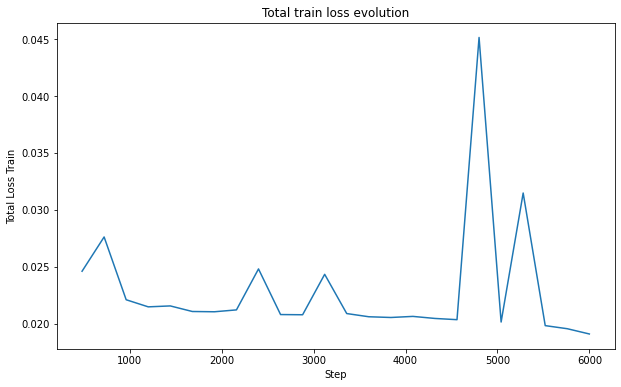

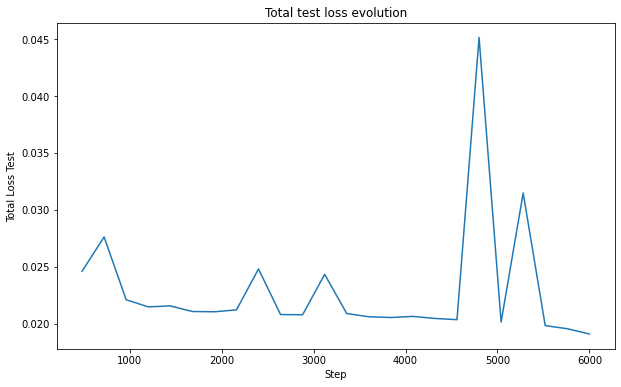

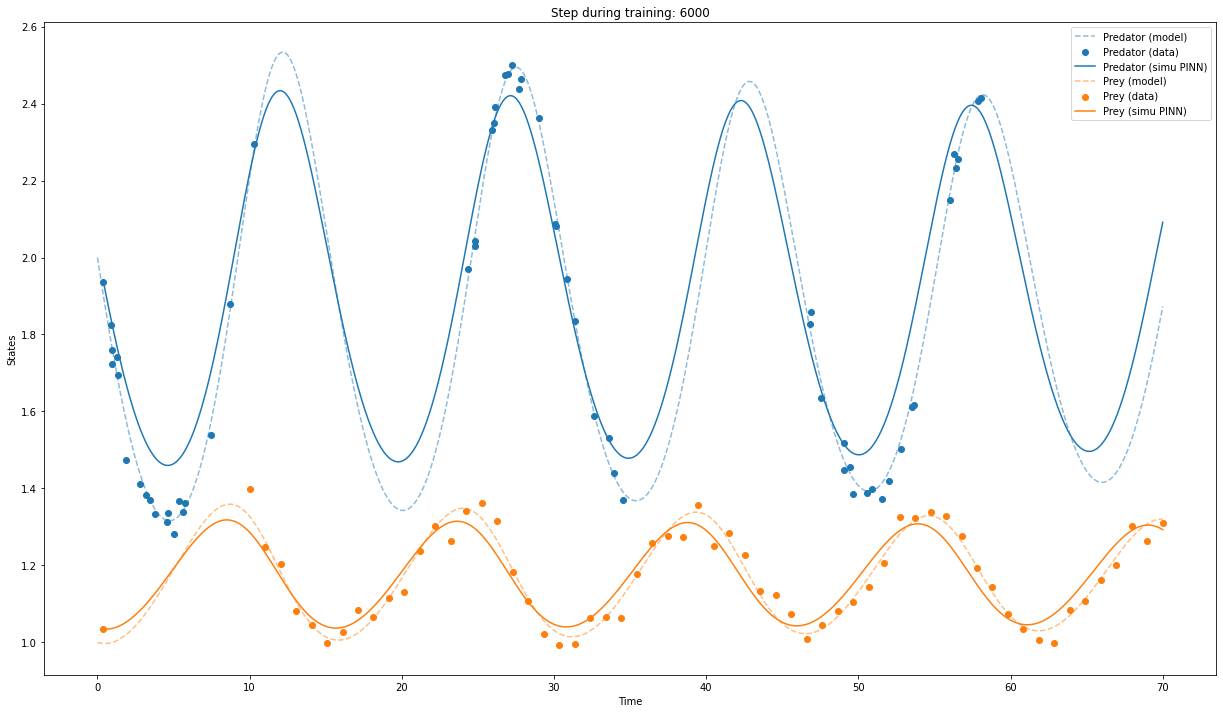

In [23]:
fitted_params = ['kappa_tild']
dimless_params_2pop_fitted = {key: value * (1+np.random.normal(0, 0.1)) \
                              for key, value in dimless_params_2pop.items() if key in fitted_params}
dimless_params_2pop_fixed = {key: value for key, value in dimless_params_2pop.items() if key not in fitted_params}
model_pinn_LV2_4 = pinn(lv_model_2pop_derivatives, datagen_LV2_2, 
                        dimless_params_2pop_fitted, dimless_params_2pop_fixed)
model_pinn_LV2_4.get_train_data()
bc_weights, data_weights, pde_weights = [5,5], [0.2,0.2], [10,10]
weights = [pde_weights + bc_weights + data_weights]
lr = 1e-3

model_pinn_LV2_4.compile_train_model(lr=lr, nnlayers = [1] + [128] * 3 + [2], activation_function="swish", initcond="Glorot normal",
                              weights=weights, niter_weights=[6000], metrics=[], file_var_export='LV2_4')

model_pinn_LV2_4.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=None)
model_pinn_LV2_4.plot_convergence(file_save_fig=None)
model_pinn_LV2_4.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]},
                                        file_save_fig=None, nb_p_t=10000)
model_pinn_LV2_4.plot_loss_history(file_save_fig=None, elements_to_plot=["loss_train"], 
                                   start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
model_pinn_LV2_4.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]},
                               file_save_gif='LV2_4.gif', nb_p_t=10000, max_gif_duration_in_sec=5)

### Performance function along time

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from utils.pinn import *
import utils.data_generator as dg
import utils.sample_plan as sp
from utils.models_catalogue import lv_model_2pop_derivatives, eco_to_dimless_2pop

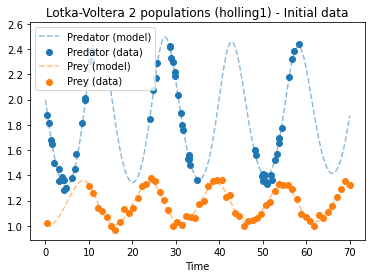

In [8]:
Tref = 10
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                   "b":1/0.12, "Tref": Tref, "func_resp": "holling1", "a": 0.086} # b = e/S
dimless_params_2pop = eco_to_dimless_2pop(eco_params_2pop, func_resp=eco_params_2pop["func_resp"])
dimless_params_2pop["func_resp"], dimless_params_2pop["Tref"] = eco_params_2pop["func_resp"], Tref
t_max = 70
X_ini = [2, 1] # Predator, Prey

datagen_LV2_perf = dg.data_generator(lv_model_2pop_derivatives, dimless_params_2pop, t_max, X_ini, labels_states=["Predator", "Prey"], 
                                  model_name=f"Lotka-Voltera 2 populations ({dimless_params_2pop['func_resp']})")
sample_plan_LV2_perf = [sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2}),
                     sp.sample_plan(tmax=t_max, plan_type="custom", custom_plan=np.linspace(10, t_max, 60))]
datagen_LV2_perf.get_data(plan=sample_plan_LV2_perf, noise_intensity=0.03, noise_seed=None, plot_data=True, 
                      permissible_range=[0, np.inf], default_value=10)

In [11]:
fitted_params = ['kappa_tild', 'Tr1_tild', 'Tr2_tild']
dimless_params_2pop_fitted = {key: value * (1+np.random.normal(0, 0.1)) \
                              for key, value in dimless_params_2pop.items() if key in fitted_params}
dimless_params_2pop_fixed = {key: value for key, value in dimless_params_2pop.items() if key not in fitted_params}

nn_architecture = [1, 128, 128, 128, 2]
lr = 1e-3
n_steps = 5
niter_weights=[3000] * n_steps
weights = [[5, 5, 0.5, 0.5, 10, 10]] * n_steps # [[PDE, BC, Data]]

path_for_export = "LV2_test_perf"

# Adjust the PINN
model_pinn_LV2_testperf = pinn(lv_model_2pop_derivatives, datagen_LV2_perf, 
                           dimless_params_2pop_fitted, dimless_params_2pop_fixed)
model_pinn_LV2_testperf.get_train_data()
model_pinn_LV2_testperf.compile_train_model(lr=lr, nnlayers = nn_architecture, activation_function="swish", initcond="Glorot normal",
                                   weights=weights, niter_weights=niter_weights, file_var_export=path_for_export+"-loss_hist_train.dat")

- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild ; Tr1_tild ; Tr2_tild
Fixed parameters:  Tc_tild ; Ta_tild ; lambda_tild ; func_resp ; Tref
Learning rate:  0.001
Architecture:  [1, 128, 128, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...


c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.227517 s

'compile' took 2.445359 s

Training model...

0         [1.35e+01, 3.83e-03, 1.76e+00, 5.23e-01, 1.56e+01, 3.32e+01]    [1.35e+01, 3.83e-03, 1.76e+00, 5.23e-01, 1.56e+01, 3.32e+01]    []  
120       [7.25e-02, 2.15e-02, 3.05e-01, 2.04e-02, 1.04e+00, 1.45e-01]    [7.25e-02, 2.15e-02, 3.05e-01, 2.04e-02, 1.04e+00, 1.45e-01]    []  
240       [3.04e-02, 1.90e-02, 1.49e-03, 3.81e-04, 5.13e-01, 1.41e-01]    [3.04e-02, 1.90e-02, 1.49e-03, 3.81e-04, 5.13e-01, 1.41e-01]    []  
360       [1.57e-02, 1.55e-02, 2.39e-05, 9.96e-05, 4.55e-01, 1.47e-01]    [1.57e-02, 1.55e-02, 2.39e-05, 9.96e-05, 4.55e-01, 1.47e-01]    []  
480       [1.26e-02, 1.51e-02, 1.00e-06, 3.14e-05, 4.15e-01, 1.47e-01]    [1.26e-02, 1.51e-02, 1.00e-06, 3.14e-05, 4.15e-01, 1.47e-01]    []  
600       [1.11e-02, 1.61e-02, 3.35e-05, 3.25e-05, 3.71e-01, 1.45e-01]    [1.11e-02, 1.61e-02, 3.35e-05, 3.25e-05, 3.71e-01, 1.45e-01]    []  
720       [1.03e-02, 1.88e-02, 1.00e-04, 5.77e-05, 3.01e-01, 1.39e-01] 

{'AfterStep1': {'True parameters fixed:': {'Tc_tild': 13.31033307777494, 'Ta_tild': 96.89922480620156, 'lambda_tild': 0.6521666666666667, 'func_resp': 'holling1', 'Tref': 10}, 'True parameters fitted:': {'kappa_tild': 0.030940000000000002, 'Tr1_tild': 11.363636363636365, 'Tr2_tild': 50.0}, 'Final fitted parameters:': {'kappa_tild': -0.09284675, 'Tr1_tild': 11.576611, 'Tr2_tild': 56.74567}, 'Training time (in sec):': 37.2416136264801, 'MSE data-prediction NN:': 0.00801625057767784, 'MSE data-prediction model with fitted parameters:': 0.01616637496235573, 'MSE true model-prediction NN:': 0.26676088074520055, 'MSE true model-prediction model with fitted parameters:': 0.022800822808620638}, 'AfterStep2': {'True parameters fixed:': {'Tc_tild': 13.31033307777494, 'Ta_tild': 96.89922480620156, 'lambda_tild': 0.6521666666666667, 'func_resp': 'holling1', 'Tref': 10}, 'True parameters fitted:': {'kappa_tild': 0.030940000000000002, 'Tr1_tild': 11.363636363636365, 'Tr2_tild': 50.0}, 'Final fitted 

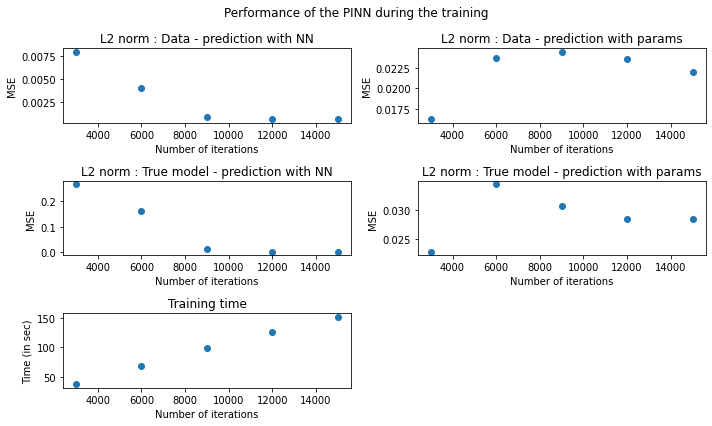

In [13]:
print(model_pinn_LV2_testperf.dict_perf)

n_iter = [sum(niter_weights[:i]) for i in range(1, n_steps+1)]
time_full_train_in_sec = []
MSE_data_NNpred = []
MSE_data_modelNNparams = []
MSE_true_NNpred = []
MSE_true_modelNNparams = []
for k in range(n_steps):
    time_full_train_in_sec.append(model_pinn_LV2_testperf.dict_perf['AfterStep'+str(k+1)]["Training time (in sec):"])
    MSE_data_NNpred.append(model_pinn_LV2_testperf.dict_perf['AfterStep'+str(k+1)]["MSE data-prediction NN:"])
    MSE_data_modelNNparams.append(model_pinn_LV2_testperf.dict_perf['AfterStep'+str(k+1)]["MSE data-prediction model with fitted parameters:"])
    MSE_true_NNpred.append(model_pinn_LV2_testperf.dict_perf['AfterStep'+str(k+1)]["MSE true model-prediction NN:"])
    MSE_true_modelNNparams.append(model_pinn_LV2_testperf.dict_perf['AfterStep'+str(k+1)]["MSE true model-prediction model with fitted parameters:"])
    

plt.figure(figsize=(10, 6))
plt.subplot(3, 2, 1) ; plt.scatter(n_iter, MSE_data_NNpred) ; plt.xlabel("Number of iterations") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with NN")
plt.subplot(3, 2, 2) ; plt.scatter(n_iter, MSE_data_modelNNparams) ; plt.xlabel("Number of iterations") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with params")
plt.subplot(3, 2, 3) ; plt.scatter(n_iter, MSE_true_NNpred) ; plt.xlabel("Number of iterations") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with NN")
plt.subplot(3, 2, 4) ; plt.scatter(n_iter, MSE_true_modelNNparams) ; plt.xlabel("Number of iterations") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with params")
plt.subplot(3, 2, 5) ; plt.scatter(n_iter, time_full_train_in_sec) ; plt.xlabel("Number of iterations") ; plt.ylabel("Time (in sec)") ; plt.title("Training time")
plt.suptitle("Performance of the PINN during the training")
plt.tight_layout()
plt.show()

## LV 6 populations

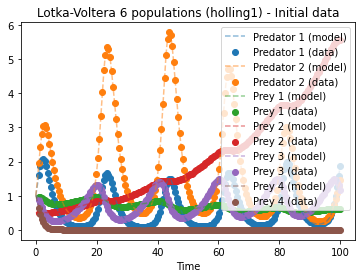

In [24]:
from utils.models_catalogue import lv_model_Npop_derivatives_noarray, params_6pop_dimless, dict_dimless_params_compact_to_long

func_resp = 'holling1'

Tref = 10
n_preds, n_preys = 2, 4
if func_resp == "holling1" or func_resp == "holling1_sat":  suff_hol = "H1"
elif func_resp == "holling2":                               suff_hol = "H2"
elif func_resp == "holling3":                               suff_hol = "H3"

dimless_params_6pop = {"kappa_tild": params_6pop_dimless["kappa_tild"],
                        "Tc_tild": params_6pop_dimless["Tc_tild_"+suff_hol],
                        "Ta_tild": params_6pop_dimless["Ta_tild_"+suff_hol],
                        "lambda_tild": params_6pop_dimless["lambda_tild_"+suff_hol],
                        "Tr_tild": params_6pop_dimless["Tr_tild"] }
dimless_params_6pop["func_resp"], dimless_params_6pop["Tref"] = func_resp, Tref
dimless_params_6pop["n_preds"], dimless_params_6pop["n_preys"] = n_preds, n_preys
dimless_params_6pop_long = dict_dimless_params_compact_to_long(dimless_params_6pop)

t_max = 100
X_ini = [1, 1, 1, 0.5, 1, 1]

# sample_plan_LV6_2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2})
# sample_plan_LV6_2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="random")
sample_plan_LV6_2 = sp.sample_plan(tmax=t_max, plan_type="custom", custom_plan=np.linspace(1, t_max, 200))
# sample_plan_LV6_2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="uniform")

datagen_LV6_2 = dg.data_generator(lv_model_Npop_derivatives_noarray, dimless_params_6pop_long, t_max, X_ini, 
                                  labels_states=["Predator " + str(k+1) for k in range(n_preds)] + ["Prey " + str(k+1) for k in range(n_preys)], 
                                  model_name=f"Lotka-Voltera 6 populations ({dimless_params_6pop_long['func_resp']})")
datagen_LV6_2.get_data(plan=sample_plan_LV6_2, noise_intensity=0, noise_seed=None, plot_data=True, 
                      permissible_range=[0, np.inf], default_value=0, nb_p_t_simu=15000)

- - - - Train the PINN - - - -
Fitted parameters:  Tc_tild_pred1prey1 ; Ta_tild_pred1prey1
Fixed parameters:  kappa_tild_prey1 ; kappa_tild_prey2 ; kappa_tild_prey3 ; kappa_tild_prey4 ; lambda_tild_pred1prey1 ; Tc_tild_pred1prey2 ; Ta_tild_pred1prey2 ; lambda_tild_pred1prey2 ; Tc_tild_pred1prey3 ; Ta_tild_pred1prey3 ; lambda_tild_pred1prey3 ; Tc_tild_pred1prey4 ; Ta_tild_pred1prey4 ; lambda_tild_pred1prey4 ; Tc_tild_pred2prey1 ; Ta_tild_pred2prey1 ; lambda_tild_pred2prey1 ; Tc_tild_pred2prey2 ; Ta_tild_pred2prey2 ; lambda_tild_pred2prey2 ; Tc_tild_pred2prey3 ; Ta_tild_pred2prey3 ; lambda_tild_pred2prey3 ; Tc_tild_pred2prey4 ; Ta_tild_pred2prey4 ; lambda_tild_pred2prey4 ; Tr_tild_pred1 ; Tr_tild_pred2 ; Tr_tild_prey1 ; Tr_tild_prey2 ; Tr_tild_prey3 ; Tr_tild_prey4 ; func_resp ; Tref ; n_preds ; n_preys
Learning rate:  0.001
Architecture:  [1, 128, 128, 6] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...
'build' took 0.062944 s



c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.740134 s

Training model...

Step      Train loss                                                                                                                                                                              Test loss                                                                                                                                                                               Test metric
0         [5.23e+03, 1.31e+04, 4.56e+00, 1.50e+00, 2.28e+01, 1.19e-01, 1.39e+01, 1.91e+01, 4.07e+00, 1.20e+00, 3.29e+00, 1.76e+00, 1.63e+02, 5.82e+02, 1.99e+02, 1.59e+02, 1.87e+01, 3.78e+01]    [5.23e+03, 1.31e+04, 4.56e+00, 1.50e+00, 2.28e+01, 1.19e-01, 1.39e+01, 1.91e+01, 4.07e+00, 1.20e+00, 3.29e+00, 1.76e+00, 1.63e+02, 5.82e+02, 1.99e+02, 1.59e+02, 1.87e+01, 3.78e+01]    []  
80        [5.06e-01, 1.22e+00, 3.11e-02, 1.35e-02, 4.80e-02, 6.03e-02, 2.10e+00, 2.43e+00, 1.35e+00, 8.27e-02, 1.76e+00, 6.02e-01, 2.89e+00, 2.47e+01, 4.27e-01, 1.71e+00, 1.49e+00, 

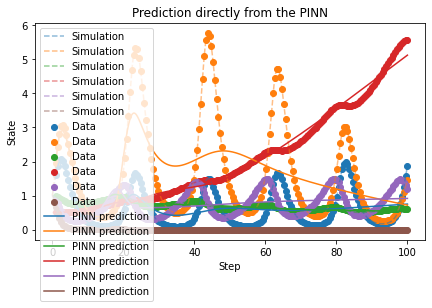

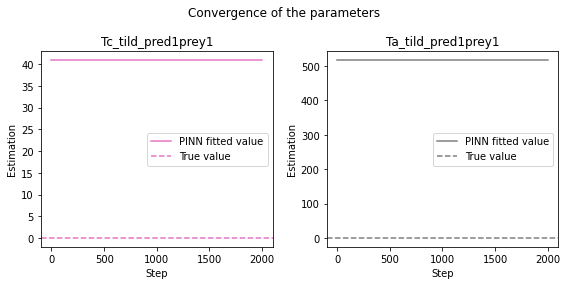

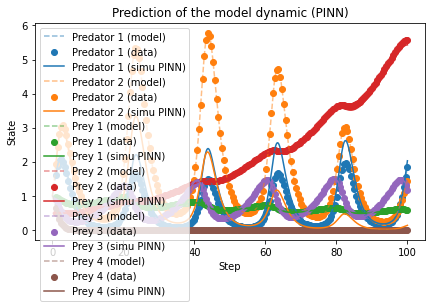

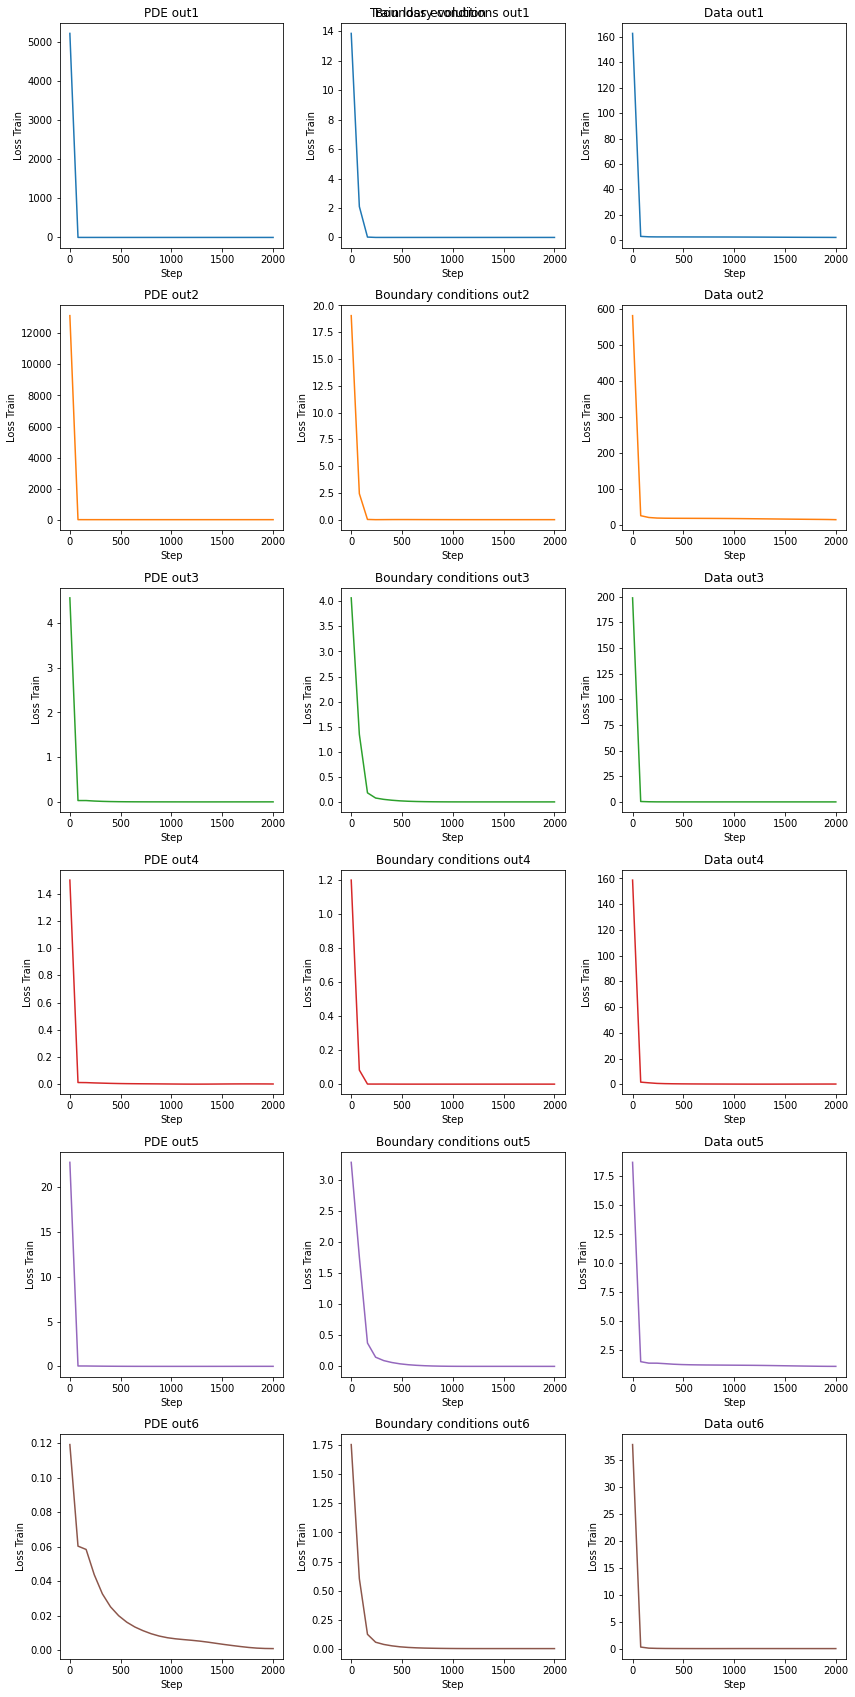

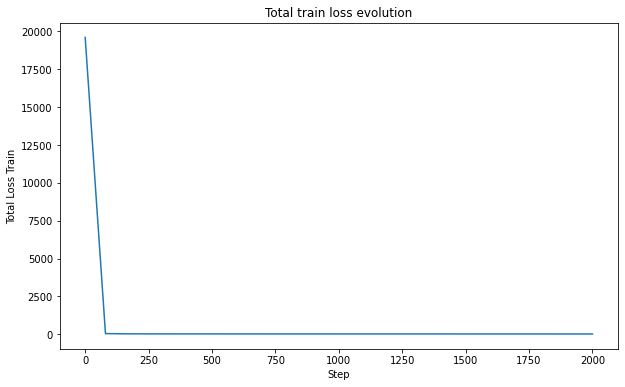

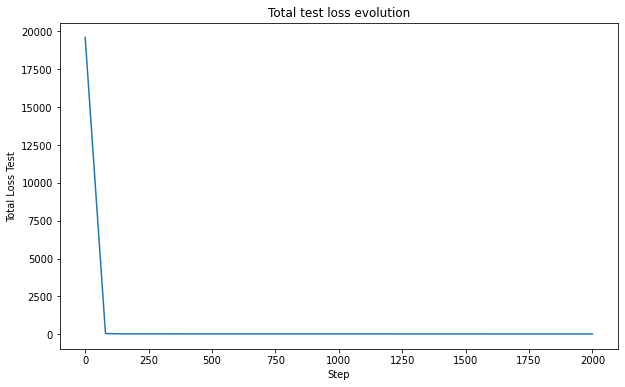

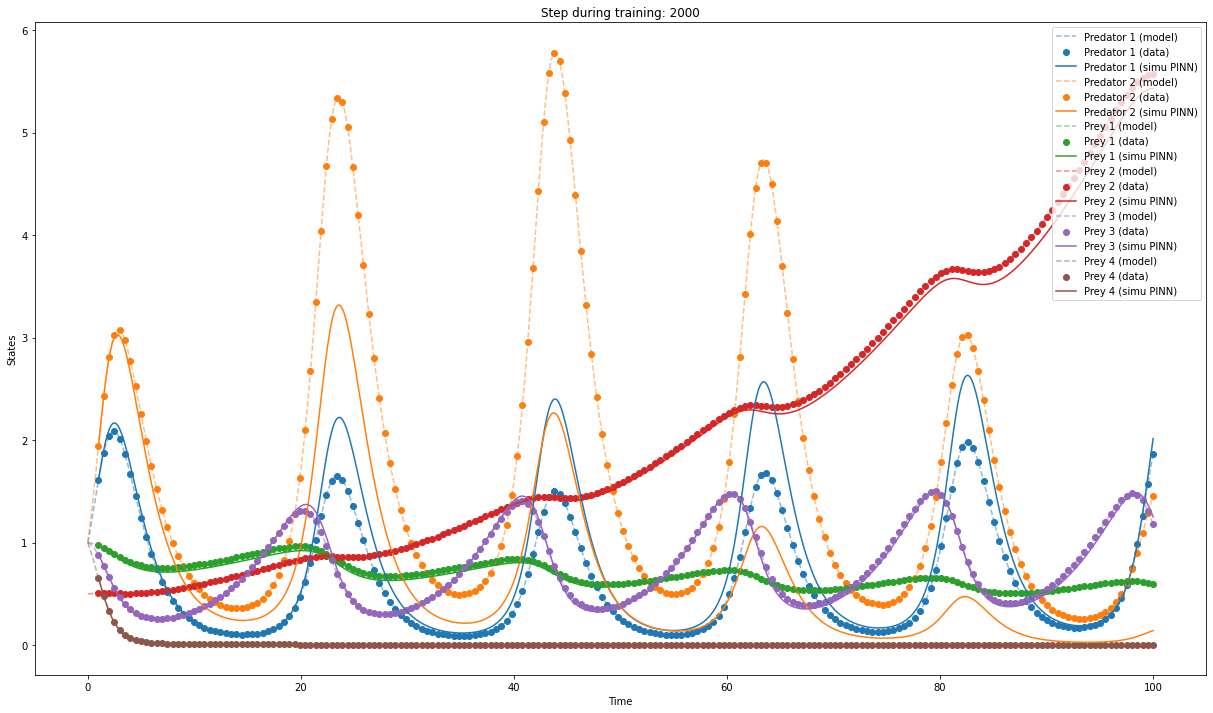

In [25]:
fitted_params = ['Tc_tild_pred1prey1', 'Ta_tild_pred1prey1']
# fitted_params = [item for item in list(dimless_params_6pop_long.keys()) if item not in ('func_resp', 'Tref', 'n_preds', 'n_preys')]
dimless_params_6pop_fitted = {key: value * (1+np.random.normal(0, 0.1)) \
                                for key, value in dimless_params_6pop_long.items() if key in fitted_params}
dimless_params_6pop_fixed = {key: value for key, value in dimless_params_6pop_long.items() if key not in fitted_params}

model_pinn_LV6_2 = pinn(lv_model_Npop_derivatives_noarray, datagen_LV6_2, 
                        dimless_params_6pop_fitted, dimless_params_6pop_fixed)
model_pinn_LV6_2.get_train_data()
bc_weights, data_weights, pde_weights = [5]*6, [10]*6, [10]*6
weights = [pde_weights + bc_weights + data_weights]
lr = 1e-3

model_pinn_LV6_2.compile_train_model(lr=lr, nnlayers = [1] + [128] * 2 + [6], activation_function="swish", initcond="Glorot normal",
                              weights=weights, niter_weights=[2000], metrics=[], file_var_export='LV6_2')

lst_plots = list(range(6))
model_pinn_LV6_2.basic_plot(elements_to_plot={"simulation":lst_plots, "data":lst_plots, "prediction":lst_plots}, file_save_fig=None)
model_pinn_LV6_2.plot_convergence(file_save_fig=None)
model_pinn_LV6_2.plot_predicted_dynamic(elements_to_plot={"simulation":lst_plots, "data":lst_plots, "prediction":lst_plots},
                                        file_save_fig=None, nb_p_t=10000)
model_pinn_LV6_2.plot_loss_history(file_save_fig=None, elements_to_plot=["loss_train"],
                                   start_step_idx=0, labels_loss = ["PDE", "Boundary conditions",  "Data"])
model_pinn_LV6_2.gif_evolution(elements_to_plot={"simulation":lst_plots, "data":lst_plots, "prediction":lst_plots},
                               file_save_gif='LV6_2.gif', nb_p_t=10000, max_gif_duration_in_sec=5)

# Scipy solver
*[Here](utils/scipy_fitting.py) is the concerned file.*

This class aims at finding the parameters of the dynamics, from the sampled data and the chosen dynamics. 

First, we need to define the solver using the model and the data generator : `scipy_solver_exp_1 = sf.scipy_fitting(exp_decay_model_derivatives, datagen_exp2)`. 

Then, we associate the solver to the generated data : `scipy_solver_exp_1.get_train_data(new_gen_data=False, permissible_range=[-np.inf, np.inf], default_value=0)`.

Now, we can fit the parameters : `scipy_solver_exp_1.predict(params0=param, X_0=[x_ini], fixed_params={})`.

And display the adjusted dynamics : `scipy_solver_exp_1.basic_plot(elements_to_plot={"simulation":[0], "data":[0], "prediction":[0]}, file_save_fig=None)`. 

In [1]:
import utils.scipy_fitting as sf

from utils.models_catalogue import exp_decay_model_derivatives, lv_model_Npop_derivatives_noarray, lv_model_2pop_derivatives
from utils.models_catalogue import eco_to_dimless_2pop, params_6pop_dimless
import utils.data_generator as dg
import utils.sample_plan as sp

import matplotlib.pyplot as plt
import numpy as np

## Exponential decay

We will use the same t_samples for all states for the curve_fit method
Prediction with curve_fit method (common t_samples)


{'True parameters fixed:': {},
 'True parameters fitted:': {'k': 0.5},
 'Final fitted parameters:': {'k': 0.34985858408512466},
 'Training time (in sec):': 0.14358139038085938,
 'MSE data-prediction scipy:': 0.06630590831088241,
 'MSE true model-prediction scipy:': 0.03160398690980928}

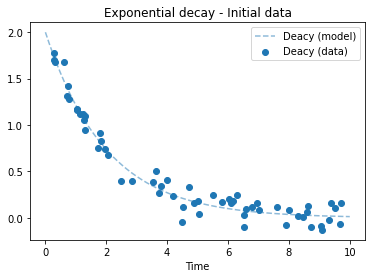

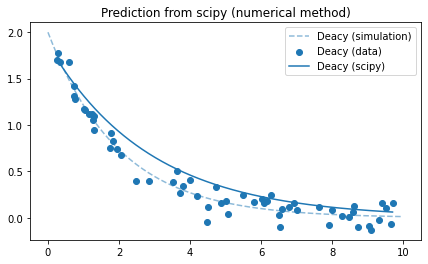

In [2]:
param = {"k": 0.5}
t_max, x_ini = 10, 2
sample_plan_exp2 = sp.sample_plan(tmax=t_max, nbpoint=60, plan_type="random")
datagen_exp2 = dg.data_generator(exp_decay_model_derivatives, param, t_max, [x_ini], 
                                labels_states=["Deacy"], model_name="Exponential decay")
datagen_exp2.get_data(plan=sample_plan_exp2, noise_intensity=0.1, noise_seed=None, plot_data=True, 
                    permissible_range=[-np.inf, np.inf], default_value=0)

scipy_solver_exp_1 = sf.scipy_fitting(exp_decay_model_derivatives, datagen_exp2)
scipy_solver_exp_1.get_train_data(new_gen_data=False, permissible_range=[-np.inf, np.inf], default_value=0)

t_rebuild, state_rebuild = scipy_solver_exp_1.predict(params0=param, X_0=[x_ini], fixed_params={})

scipy_solver_exp_1.basic_plot(elements_to_plot={"simulation":[0], "data":[0], "prediction":[0]}, file_save_fig=None)

scipy_solver_exp_1.performance()

## LV 2 populations

We will use the t_samples for each state for the minimize method
Prediction with minimize method (different t_samples)


{'True parameters fixed:': {'Tr1_tild': 11.363636363636365,
  'Tr2_tild': 50.0,
  'Tc_tild': 13.31033307777494,
  'Ta_tild': 96.89922480620156,
  'lambda_tild': 0.6521666666666667,
  'func_resp': 'holling1',
  'Tref': 10},
 'True parameters fitted:': {'kappa_tild': 0.030940000000000002},
 'Final fitted parameters:': {'kappa_tild': 0.030987040374654048},
 'Training time (in sec):': 2.6966238021850586,
 'MSE data-prediction scipy:': 0.010350556645255622,
 'MSE true model-prediction scipy:': 2.69925752468095e-07}

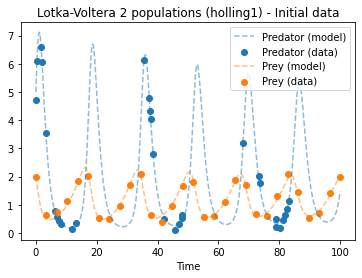

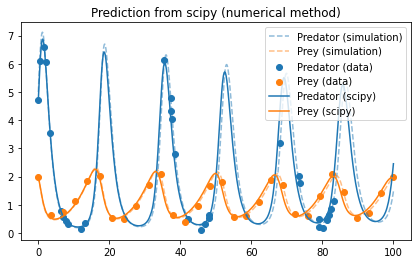

In [3]:
Tref = 10
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                "b":1/0.12, "Tref": Tref, "func_resp": "holling1", "a": 0.086} # b = e/S
# eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
#                 "b":1/0.12, "Tref": Tref, "func_resp": "holling2", "a": 0.13}  # b = e/S
# eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
#                 "b":1/0.12, "Tref": Tref, "func_resp": "holling3", "a": 1.6}   # b = e/S
dimless_params_2pop = eco_to_dimless_2pop(eco_params_2pop, func_resp=eco_params_2pop["func_resp"])
dimless_params_2pop["func_resp"], dimless_params_2pop["Tref"] = eco_params_2pop["func_resp"], Tref

t_max = 100
X_ini = [5, 2] # Predator, Prey

# sample_plan_LV2_1 = sp.sample_plan(tmax=t_max, nbpoint=30, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2})
sample_plan_LV2_1 = [sp.sample_plan(tmax=t_max, nbpoint=30, plan_type="batch_random", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2}),
                     sp.sample_plan(tmax=t_max, nbpoint=30, plan_type="uniform", batch_params={"nbr_batch": 3, "ratio_in_out_batch": 1/2})]

datagen_LV2_1 = dg.data_generator(lv_model_2pop_derivatives, dimless_params_2pop, t_max, X_ini, labels_states=["Predator", "Prey"], 
                                model_name=f"Lotka-Voltera 2 populations ({dimless_params_2pop['func_resp']})")
datagen_LV2_1.get_data(plan=sample_plan_LV2_1, noise_intensity=0.1, noise_seed=None, plot_data=True, 
                        permissible_range=[0, np.inf], default_value=0)

scipy_solver_LV2_1 = sf.scipy_fitting(lv_model_2pop_derivatives, datagen_LV2_1)
scipy_solver_LV2_1.get_train_data(new_gen_data=False, permissible_range=[0, np.inf], default_value=0)

fitted_params = ['kappa_tild']
dimless_params_2pop_fitted = {key: value * (1+np.random.normal(0, 0.1)) \
                                for key, value in dimless_params_2pop.items() if key in fitted_params}
dimless_params_2pop_fixed = {key: value for key, value in dimless_params_2pop.items() if key not in fitted_params}
t_rebuild, state_rebuild = scipy_solver_LV2_1.predict(params0=dimless_params_2pop_fitted, X_0=X_ini, fixed_params=dimless_params_2pop_fixed)

scipy_solver_LV2_1.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=None)

scipy_solver_LV2_1.performance()

## LV 6 populations

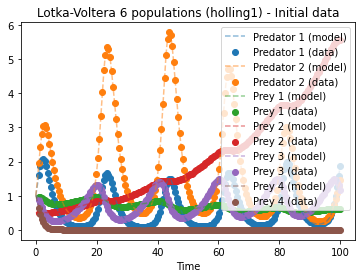

In [4]:
from utils.models_catalogue import lv_model_Npop_derivatives_noarray, params_6pop_dimless, dict_dimless_params_compact_to_long

func_resp = 'holling1'

Tref = 10
n_preds, n_preys = 2, 4
if func_resp == "holling1" or func_resp == "holling1_sat":  suff_hol = "H1"
elif func_resp == "holling2":                               suff_hol = "H2"
elif func_resp == "holling3":                               suff_hol = "H3"

dimless_params_6pop = {"kappa_tild": params_6pop_dimless["kappa_tild"],
                        "Tc_tild": params_6pop_dimless["Tc_tild_"+suff_hol],
                        "Ta_tild": params_6pop_dimless["Ta_tild_"+suff_hol],
                        "lambda_tild": params_6pop_dimless["lambda_tild_"+suff_hol],
                        "Tr_tild": params_6pop_dimless["Tr_tild"] }
dimless_params_6pop["func_resp"], dimless_params_6pop["Tref"] = func_resp, Tref
dimless_params_6pop["n_preds"], dimless_params_6pop["n_preys"] = n_preds, n_preys
dimless_params_6pop_long = dict_dimless_params_compact_to_long(dimless_params_6pop)

t_max = 100
X_ini = [1, 1, 1, 0.5, 1, 1]

sample_plan_LV6_3 = sp.sample_plan(tmax=t_max, plan_type="custom", custom_plan=np.linspace(1, t_max, 200))

datagen_LV6_3 = dg.data_generator(lv_model_Npop_derivatives_noarray, dimless_params_6pop_long, t_max, X_ini, 
                                  labels_states=["Predator " + str(k+1) for k in range(n_preds)] + ["Prey " + str(k+1) for k in range(n_preys)], 
                                  model_name=f"Lotka-Voltera 6 populations ({dimless_params_6pop_long['func_resp']})")
datagen_LV6_3.get_data(plan=sample_plan_LV6_3, noise_intensity=0, noise_seed=None, plot_data=True, 
                      permissible_range=[0, np.inf], default_value=0, nb_p_t_simu=15000)

We will use the same t_samples for all states for the curve_fit method
Prediction with curve_fit method (common t_samples)


{'True parameters fixed:': {'kappa_tild_prey1': 0.055,
  'kappa_tild_prey2': 0.014,
  'kappa_tild_prey3': 0.031,
  'kappa_tild_prey4': 0.03,
  'lambda_tild_pred1prey1': 0.19,
  'Tc_tild_pred1prey2': 3100.0,
  'Ta_tild_pred1prey2': 1100.0,
  'lambda_tild_pred1prey2': 0.0028,
  'Tc_tild_pred1prey3': 13.0,
  'Ta_tild_pred1prey3': 98.0,
  'lambda_tild_pred1prey3': 0.64,
  'Tc_tild_pred1prey4': 41.0,
  'Ta_tild_pred1prey4': 100.0,
  'lambda_tild_pred1prey4': 0.21,
  'Tc_tild_pred2prey1': 33.0,
  'Ta_tild_pred2prey1': 920.0,
  'lambda_tild_pred2prey1': 0.29,
  'Tc_tild_pred2prey2': 4100.0,
  'Ta_tild_pred2prey2': 3100.0,
  'lambda_tild_pred2prey2': 0.0023,
  'Tc_tild_pred2prey3': 16.0,
  'Ta_tild_pred2prey3': 250.0,
  'lambda_tild_pred2prey3': 0.59,
  'Tc_tild_pred2prey4': 22.0,
  'Ta_tild_pred2prey4': 67.0,
  'lambda_tild_pred2prey4': 0.43,
  'Tr_tild_pred1': 11,
  'Tr_tild_pred2': 11,
  'Tr_tild_prey1': 286,
  'Tr_tild_prey2': 238,
  'Tr_tild_prey3': 50,
  'Tr_tild_prey4': 189,
  'func_res

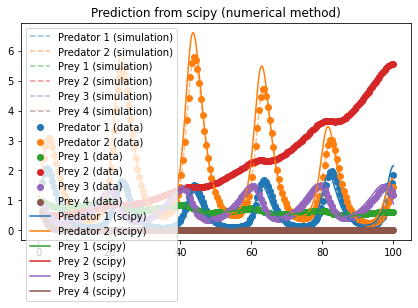

In [5]:
scipy_solver_LV6_3 = sf.scipy_fitting(lv_model_Npop_derivatives_noarray, datagen_LV6_3)
scipy_solver_LV6_3.get_train_data(new_gen_data=False, permissible_range=[0, np.inf], default_value=0)

fitted_params = ['Tc_tild_pred1prey1', 'Ta_tild_pred1prey1']
dimless_params_6pop_fitted = {key: value * (1+np.random.normal(0, 0.1)) \
                                for key, value in dimless_params_6pop_long.items() if key in fitted_params}
dimless_params_6pop_fixed = {key: value for key, value in dimless_params_6pop_long.items() if key not in fitted_params}
t_rebuild, state_rebuild = scipy_solver_LV6_3.predict(params0=dimless_params_6pop_fitted, X_0=X_ini, fixed_params=dimless_params_6pop_fixed)

scipy_solver_LV6_3.basic_plot(elements_to_plot={"simulation":list(range(6)), "data":list(range(6)), "prediction":list(range(6))}, file_save_fig=None)

scipy_solver_LV6_3.performance()